 - Previous Notebooks (repository links)
   - **[Data Collection](https://github.com/NBPub/Springboard/blob/main/Capstone%20Two/7.6_Wrangling.ipynb)**
   - **[EDA](https://github.com/NBPub/Springboard/blob/main/Capstone%20Two/11.6_EDA.ipynb)**
   - **[PreProcessing](https://github.com/NBPub/Springboard/blob/main/Capstone%20Two/16.3_Preprocessing-Training.ipynb)**
   - Other
     - [PyCaret Tuning](https://github.com/NBPub/Springboard/blob/main/Capstone%20Two/PyCaret%20Notebooks/18.3_PYC_Modeling_selection.ipynb)
     - [PyCaret Blending](https://github.com/NBPub/Springboard/blob/main/Capstone%20Two/PyCaret%20Notebooks/18.3_PYC_Modeling_final.ipynb)
     - [Outlier Detection](https://github.com/NBPub/Springboard/blob/main/Capstone%20Two/11.6_EDA_outlier-detection.ipynb)

## Contents
 - [Data Load, Split](#Load-Data)
 - [Model Selection, Hyperparamter Tuning](#Model-Selection,-Tuning)
   - [linear+kNN tuning testing](#Linear-Tuning)
   - [ensemble tuning testing](#Ensemble-Tuning)
 - [Outlier Detection Study](#Test-Outlier-Detection)
   - remove failed attempts
 - [Top Models - Blending Study](#Top-Model-Blending)
 - [Final Model, Residual Analysis for Test Set](#Best-Model-+-Resiudal-Analysis)
   - [Other Plots - Feature Importance, etc](#Other-Plots)
   - [Final Blend vs CatBoost - Residual Analysis](#Compare-to-CatBoost-(2nd-place))
 ---

In [1]:
from time import time
from tqdm import tqdm
from pathlib import Path
from joblib import dump,load

import pandas as pd
import numpy as np
np.random.seed(42)
from scipy.stats import loguniform, powerlaw, uniform, nbinom, randint, boltzmann, binom, beta
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.base import TransformerMixin
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, IsolationForest, VotingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoost, CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb

### Load Data

In [2]:
data = pd.read_parquet(Path('data/game_stats.parquet'))
X = data.iloc[:,6:-2]
y = data['home_margin'] # target for regression

# Initial Split, this test set will be hold out for scoring
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
features = X_train.columns
print(X_train.shape)
print(X_test.shape)

(1216, 12)
(305, 12)


**Check target feature spread across datasets**

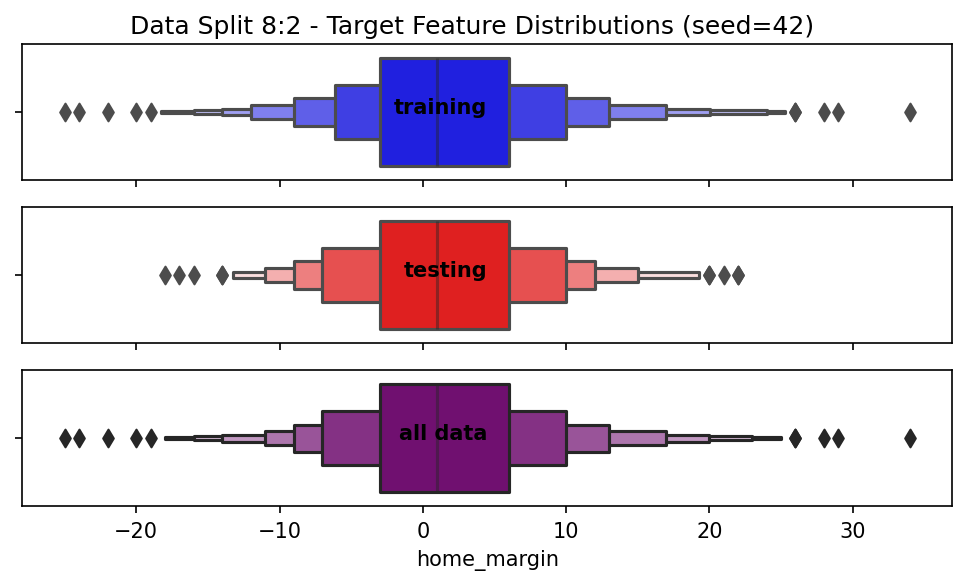

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, sharey=True, figsize=(8,4), dpi=150)

sns.boxenplot(x=y_train, ax=ax1, color='blue')
ax1.set_title('training', fontsize=10, fontweight='bold', y=0.4, ha='right')
sns.boxenplot(x=y_test, ax=ax2, color='red')
ax2.set_title('testing', fontsize=10, fontweight='bold', y=0.4, ha='right')
sns.boxenplot(x=y, ax=ax3, color='purple')
ax3.set_title('all data', fontsize=10, fontweight='bold', y=0.4, ha='right')

ax1.set_xlabel('')
ax2.set_xlabel('')
fig.suptitle('Data Split 8:2 - Target Feature Distributions (seed=42)', y=0.93, fontsize=12)

#plt.savefig('data_split.png')
plt.show()

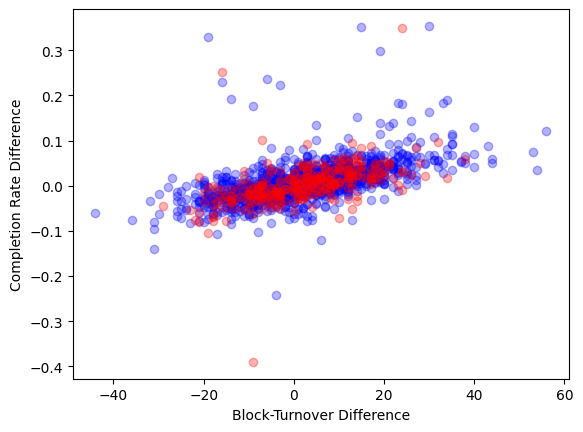

In [4]:
#plt.scatter(x=X['block_turnover_diff'], y=X['comp_rate_diff'], alpha=0.5, color='purple')
plt.scatter(x=X_train['block_turnover_diff'], y=X_train['comp_rate_diff'], alpha=0.3, color='blue')
plt.scatter(x=X_test['block_turnover_diff'], y=X_test['comp_rate_diff'], alpha=0.3, color='red')
plt.ylabel('Completion Rate Difference')
plt.xlabel('Block-Turnover Difference')
plt.show()

### Model Selection, Tuning
 - **continue with GradientBoosting, kNN, CatBoost, XGB (gbtree)**
   - [visualize probability distributions](https://nbpub.pythonanywhere.com/)

In [74]:
tuning_grids = {
    'SGDRegressor': { 'iterations': 300, 'grid': {
        # leave loss function, penalty, learning_rate, fit_intercept at defaults: 'squared_error', 'L2', 'invscaling', True
        # vary alpha, tol(erance), eta0, power_t
        'alpha': loguniform(8e-5, 1e-2, 0, 1), # def=1e-4, float | higher values increase regularization strength
        'tol': loguniform(1e-5, 1e-2, 0, 1), # def=1e-3, float or None | convergence parameter
        'eta0': loguniform(1e-2, 8e-1, 0, 1), # def=0.01, float | initial learning rate
        'power_t': powerlaw(1, 0, 1), # def=0.25, float | exponent for invscaling learning rate: eta = eta0/pow(t, power_t)
    }},
    'Ridge': { 'iterations': 300, 'grid': {
        # vary alpha, tolerance/solver (see old sheet)
        'alpha': loguniform(0.01,10,0,1), # def=1, controls regularization strength [0,inf)
        'tol': loguniform(1e-2,0.95,0,1), # def=1e-4, specifies convergence critieria for solvers: sparse_cg, lsqr, sag, saga, lbfgs
        'solver':['saga'], # def='auto', previous grid search found good performance for saga, limit this search
    }},
    'KernelRidge': { 'iterations': 30, 'grid': {
        # vary alpha. if kernel is varied to something other than linear, then can also vary gamma
        'alpha': uniform(0,2), # def=1, controls regularization strength, must be positive float
        'kernel': ['linear'], # see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_kernels.html
    }},
    'KNeighborsRegressor': { 'iterations': 60, 'grid': {
        # vary n_neighbors, weights, algorithm (k-d vs ball tree), leaf_size (keep default), p [0,1]
        'n_neighbors': randint(2,9,0), # def=5, 
        'weights': ['uniform','distance'], # def='uniform', weight function used in prediction. uniform or distance based (inverse relation)
        'algorithm': ['ball_tree', 'kd_tree'], # def='auto', brute-force, kd_tree, ball_tree
        'leaf_size': nbinom(30,0.5,1),
        'p':[1,2],
    }},
    # vary estimators, keep criterion at squared_error (friedman can work well), vary min_samples_split
    'ExtraTreesRegressor': {'iterations': 90, 'grid': {
        'n_estimators':boltzmann(0.01,200,10),  
    }},
    # vary learning rate, n_estimators. keep loss function as huber
    'GradientBoostingRegressor': {'iterations': 60, 'grid': {
        'loss':['huber'],
        'learning_rate': loguniform(.04,1,0,1),
        'n_estimators': boltzmann(0.01,200,10),
    }},
    'RandomForestRegressor': {'iterations': 60, 'grid': {
        'n_estimators':boltzmann(0.01,200,10),  
        'max_features':binom(14,0.5,0),
    }},
    'LGBMRegressor': {'iterations': 30, 'grid': {
        'num_leaves': randint(25,36,0), # def=31
        'min_data_in_leaf': randint(15,25,0),  #def=20, not listed as parameter
        'learning_rate':loguniform(0.01,0.5,0,1), # def=0.1
        'n_estimators':randint(100,300,0), # def=100, not listed as a parameter | boltzmann(0.001,500,50)
    }},
    'CatBoostRegressor': {'iterations': 20, 'grid': {
        'l2_leaf_reg':uniform(0,4), # def=3
        'random_strength':uniform(0,3), # def=1
        'learning_rate':beta(2,20,0,1), # def=0.043
    }},
    # XGB - Linear Booster
    'XGBRegressor_gblinear': {'iterations': 60, 'grid': {
        'lambda':loguniform(.001,1,0,1), # def=0, L2 regularization
        'updater':['shotgun'], # def='shotgun', descent algorithm to fit linear model
        'feature_selector': ['cyclic'], # def='cyclic', feature selection and ordering method
    }},
    # XGB - Tree
    # complexity: max_depth, min_child_weight, gamma
    # randomness: subsample, colsample_bytree. reduce eta while increasing num_round
    'XGBRegressor_gbtree': {'iterations': 60, 'grid': {
        'eta':beta(2,4,0,1), # def=0.3, learning_rate. [0,1]
        'gamma': loguniform(0.001,1,0,1), # def=0, minimum loss reduction, larger=more conservative. [0,inf)
        'max_depth': randint(2,15,0), # def=6, higher increases chances to overfit, use with learning rate
        'subsample': uniform(0.6,0.4), # def=1, (0,1]. practically vary 0.5-1
        'colsample_bytree': uniform(0.6,0.4), # def=1, subsample ratio of columns used when constructing each tree 
    }},
}

In [75]:
# linear, kNN - Select 7 or 8 features
sgd_pipe = make_pipeline(SelectKBest(score_func=f_regression, k=7), StandardScaler(), SGDRegressor(random_state=42))
ridge_pipe = make_pipeline(SelectKBest(score_func=f_regression, k=8), StandardScaler(), Ridge(random_state=42))
kr_pipe = make_pipeline(SelectKBest(score_func=f_regression, k=7), KernelRidge())
knn_pipe = make_pipeline(SelectKBest(score_func=f_regression, k=7), KNeighborsRegressor(n_jobs=-1))

# ensemble methods - Keep all features
gbr_pipe = make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=42, ))
et_pipe = make_pipeline(StandardScaler(), ExtraTreesRegressor(n_jobs=-1, random_state=42))
rf_pipe = make_pipeline(StandardScaler(), RandomForestRegressor(n_jobs=-1, random_state=42))
cat_pipe = make_pipeline(StandardScaler(), CatBoostRegressor(random_seed=42, verbose=False))
lgbm_pipe = make_pipeline(StandardScaler(), lgb.LGBMRegressor(n_jobs=-1, random_state=42, verbosity=-1))
xgb_tree_pipe = make_pipeline(StandardScaler(), xgb.XGBRegressor(booster="gbtree", ))
xgb_linear_pipe = make_pipeline(StandardScaler(), xgb.XGBRegressor(booster="gblinear", ))

In [76]:
%%time

# estimated time: 7-8 minutes on my machine

test_results = pd.DataFrame()
cv_results = pd.DataFrame()
tuning_notes = {} # iterations, time taken, resulting parameters, tuned/default cv scores

for pipe in tqdm([sgd_pipe, ridge_pipe, kr_pipe, knn_pipe, # linear+kNN take ~30s
                  cat_pipe, gbr_pipe, et_pipe, rf_pipe, lgbm_pipe, 
                  xgb_tree_pipe, xgb_linear_pipe]):
    
    ind = pipe[-1].__class__.__name__
    if ind == 'XGBRegressor':
        ind = f'{ind}_{pipe[-1].booster}'
    
    # default score: validation set and CV scores
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    cv = cross_validate(pipe, X_train, y_train,
            scoring=['r2', 'neg_mean_absolute_error','neg_root_mean_squared_error', 
                     'neg_mean_absolute_percentage_error'],
                        cv=10, n_jobs=-1)

    # cv results
    cv_results.loc[ind,'def_R2'] = np.mean(cv['test_r2'])
    cv_results.loc[ind,'def_RMSE'] = -1*np.mean(cv['test_neg_root_mean_squared_error'])
    cv_results.loc[ind,'def_MAE'] = -1*np.mean(cv['test_neg_mean_absolute_error'])
    cv_results.loc[ind,'def_MAPE'] = -1*np.median(cv['test_neg_mean_absolute_percentage_error'])
    # baseline testing
    test_results.loc[ind,'def_R2'] = r2_score(y_test,y_pred)
    test_results.loc[ind,'def_RMSE'] = np.sqrt(mean_squared_error(y_test,y_pred))
    test_results.loc[ind,'def_MAE'] = mean_absolute_error(y_test,y_pred)
    test_results.loc[ind,'def_MAPE'] = mean_absolute_percentage_error(y_test,y_pred)
    
    # tuning scores, best model scores
    if ind.startswith('XGBRegressor'):
        grid = {f'{pipe[-1].__class__.__name__.lower()}__{key}':val 
                for key,val in tuning_grids[ind]['grid'].items()}
    else:
        grid = {f'{ind.lower()}__{key}':val 
                for key,val in tuning_grids[ind]['grid'].items()}
    
    start = time()
    search = RandomizedSearchCV(pipe, grid, n_iter=tuning_grids[ind]['iterations'],
                            scoring='r2', refit=True,  random_state=42, cv=10, n_jobs=-1)
    cv = search.fit(X_train,y_train)
    y_pred = cv.best_estimator_.predict(X_test)
    stop = round(time()-start,2)
    # record tuning notes
    tuning_notes[ind] = {}
    tuning_notes[ind]['iterations'] = tuning_grids[ind]['iterations']
    tuning_notes[ind]['time'] = stop
    tuning_notes[ind]['parameters'] = cv.best_params_
    
    cv = cross_validate(cv.best_estimator_, X_train, y_train,
            scoring=['r2', 'neg_mean_absolute_error','neg_root_mean_squared_error', 
                     'neg_mean_absolute_percentage_error'],
                        cv=10, n_jobs=-1)

    # tuned cv results
    cv_results.loc[ind,'tuned_R2'] = np.mean(cv['test_r2'])
    cv_results.loc[ind,'tuned_RMSE'] = -1*np.mean(cv['test_neg_root_mean_squared_error'])
    cv_results.loc[ind,'tuned_MAE'] = -1*np.mean(cv['test_neg_mean_absolute_error'])
    cv_results.loc[ind,'tuned_MAPE'] = -1*np.median(cv['test_neg_mean_absolute_percentage_error'])
    cv_results.loc[ind,'tune_time'] = stop
    # tuned testing
    test_results.loc[ind,'tuned_R2'] = r2_score(y_test,y_pred)
    test_results.loc[ind,'tuned_RMSE'] = np.sqrt(mean_squared_error(y_test,y_pred))
    test_results.loc[ind,'tuned_MAE'] = mean_absolute_error(y_test,y_pred)
    test_results.loc[ind,'tuned_MAPE'] = mean_absolute_percentage_error(y_test,y_pred)   
    
    # tune/def test score ratio
    tuning_notes[ind]['factor'] = {
        'R2': cv_results.loc[ind,'tuned_R2'] / cv_results.loc[ind,'def_R2'],
        'RMSE' : cv_results.loc[ind,'tuned_RMSE'] / cv_results.loc[ind,'def_RMSE'],
        'MAE' : cv_results.loc[ind,'tuned_MAE'] / cv_results.loc[ind,'def_MAE'],
    }

100%|██████████| 11/11 [06:05<00:00, 33.21s/it]

CPU times: total: 1min
Wall time: 6min 5s


**Results**
 - see overfitting analysis, summary graphs below
 - metrics mostly trend with each other (ex: better R2 should mean better RMSE)
   - key exception: **kNN has low MAPE** compared to other models

In [425]:
display(cv_results.sort_values(['tuned_R2', 'def_R2'],ascending=False).style\
    .background_gradient(subset=['tuned_R2', 'def_R2'], cmap='viridis')
    .background_gradient(subset=['def_MAE','def_RMSE','def_MAPE','tuned_MAE','tuned_RMSE','tuned_MAPE'], cmap='viridis_r')
    .highlight_max(subset=['tuned_R2'],  props='font-weight:bold')
    .highlight_min(subset=['tuned_MAE','tuned_RMSE','tuned_MAPE'],  props='font-weight:bold')
    .format('{:.3f}', subset=cv_results.columns[:]))

,def_R2,def_RMSE,def_MAE,def_MAPE,tuned_R2,tuned_RMSE,tuned_MAE,tuned_MAPE,tune_time
CatBoostRegressor,0.886,2.490,1.584,0.534,0.888,2.466,1.563,0.517,116.050
XGBRegressor_gbtree,0.857,2.813,1.868,0.603,0.878,2.575,1.647,0.558,33.140
GradientBoostingRegressor,0.866,2.711,1.792,0.615,0.877,2.583,1.650,0.560,33.790
LGBMRegressor,0.863,2.752,1.787,0.591,0.870,2.677,1.758,0.587,31.290
KNeighborsRegressor,0.864,2.713,1.740,0.575,0.869,2.670,1.713,0.550,2.270
RandomForestRegressor,0.856,2.814,1.873,0.636,0.868,2.694,1.806,0.587,40.470
ExtraTreesRegressor,0.864,2.725,1.802,0.610,0.867,2.703,1.792,0.602,37.890
SGDRegressor,0.855,2.798,1.745,0.587,0.857,2.791,1.764,0.588,8.850
Ridge,0.856,2.797,1.743,0.585,0.856,2.796,1.746,0.587,3.980
KernelRidge,0.855,2.797,1.742,0.603,0.855,2.796,1.741,0.600,3.590


In [11]:
cv_results.to_csv('tuning results/training_scores.csv')
test_results.to_csv('tuning results/testing_scores.csv')

import json
with open('tuning results/tuning_notes.json', mode='w') as f:
    f.write(json.dumps(tuning_notes))

In [80]:
test_results.columns[test_results.columns.str.endswith('def_')]

Index([], dtype='object')

In [82]:
display(test_results.drop(columns=test_results.columns[test_results.columns.str.startswith('def_')])\
                    .sort_values(['tuned_R2',],ascending=False).style\
    .background_gradient(subset=['tuned_R2'], cmap='viridis')
    .background_gradient(subset=['tuned_MAE','tuned_RMSE', 'tuned_MAPE'], cmap='viridis_r')
    .highlight_max(subset=['tuned_R2'],  props='font-weight:bold')
    .highlight_min(subset=['tuned_MAE','tuned_RMSE', 'tuned_MAPE'],  props='font-weight:bold')
    .format('{:.3f}'))

,tuned_R2,tuned_RMSE,tuned_MAE,tuned_MAPE
GradientBoostingRegressor,0.847,2.801,1.719,0.459
CatBoostRegressor,0.843,2.845,1.627,0.435
XGBRegressor_gbtree,0.832,2.938,1.771,0.496
KNeighborsRegressor,0.817,3.065,1.809,0.504
ExtraTreesRegressor,0.814,3.096,1.884,0.509
RandomForestRegressor,0.810,3.129,1.911,0.516
LGBMRegressor,0.792,3.269,1.934,0.553
KernelRidge,0.780,3.365,1.928,0.516
SGDRegressor,0.776,3.393,1.965,0.527
Ridge,0.775,3.402,1.947,0.522


In [423]:
display(test_results.drop(columns=test_results.columns[test_results.columns.str.endswith('MAPE')])\
                    .sort_values(['tuned_R2', 'def_R2'],ascending=False).style\
    .background_gradient(subset=['tuned_R2', 'def_R2'], cmap='viridis')
    .background_gradient(subset=['def_MAE','def_RMSE','tuned_MAE','tuned_RMSE',], cmap='viridis_r')
    .highlight_max(subset=['tuned_R2'],  props='font-weight:bold')
    .highlight_min(subset=['tuned_MAE','tuned_RMSE',],  props='font-weight:bold')
    .format('{:.3f}'))

,def_R2,def_RMSE,def_MAE,tuned_R2,tuned_RMSE,tuned_MAE
GradientBoostingRegressor,0.810,3.128,1.927,0.847,2.801,1.719
CatBoostRegressor,0.837,2.898,1.639,0.843,2.845,1.627
XGBRegressor_gbtree,0.808,3.141,1.926,0.832,2.938,1.771
KNeighborsRegressor,0.816,3.079,1.792,0.817,3.065,1.809
ExtraTreesRegressor,0.810,3.126,1.892,0.814,3.096,1.884
RandomForestRegressor,0.785,3.323,2.020,0.810,3.129,1.911
LGBMRegressor,0.790,3.287,1.933,0.792,3.269,1.934
KernelRidge,0.780,3.361,1.921,0.780,3.365,1.928
SGDRegressor,0.775,3.404,1.935,0.776,3.393,1.965
Ridge,0.775,3.403,1.932,0.775,3.402,1.947


In [10]:
tuning_notes

{'SGDRegressor': {'iterations': 300,
  'time': 9.09,
  'parameters': {'sgdregressor__alpha': 0.00975713159353895,
   'sgdregressor__eta0': 0.021425862207195796,
   'sgdregressor__power_t': 0.39624201890265875,
   'sgdregressor__tol': 0.0018824152265188435},
  'factor': {'R2': 1.0012318964653624,
   'RMSE': 0.997520920121231,
   'MAE': 1.0108333294218028}},
 'Ridge': {'iterations': 300,
  'time': 4.25,
  'parameters': {'ridge__alpha': 2.0597335357437188,
   'ridge__solver': 'saga',
   'ridge__tol': 0.014010055495451746},
  'factor': {'R2': 1.0000815668851586,
   'RMSE': 0.9997526182998875,
   'MAE': 1.0016041300813332}},
 'KernelRidge': {'iterations': 30,
  'time': 3.81,
  'parameters': {'kernelridge__alpha': 0.27898772130408367,
   'kernelridge__kernel': 'linear'},
  'factor': {'R2': 1.000198938763856,
   'RMSE': 0.9996152680563578,
   'MAE': 0.9998901003928835}},
 'KNeighborsRegressor': {'iterations': 60,
  'time': 2.46,
  'parameters': {'kneighborsregressor__algorithm': 'kd_tree',
  

In [432]:
for key,val in tuning_notes.items():
    print(key)
    for met, score in tuning_notes[key]['factor'].items():
        print(met, round(score,4))
    print()

SGDRegressor
R2 1.0012
RMSE 0.9975
MAE 1.0108

Ridge
R2 1.0001
RMSE 0.9998
MAE 1.0016

KernelRidge
R2 1.0002
RMSE 0.9996
MAE 0.9999

KNeighborsRegressor
R2 1.0049
RMSE 0.9844
MAE 0.9844

CatBoostRegressor
R2 1.0027
RMSE 0.9904
MAE 0.9863

GradientBoostingRegressor
R2 1.0124
RMSE 0.9528
MAE 0.9206

ExtraTreesRegressor
R2 1.0027
RMSE 0.9919
MAE 0.9946

RandomForestRegressor
R2 1.0132
RMSE 0.9573
MAE 0.9642

LGBMRegressor
R2 1.0086
RMSE 0.9726
MAE 0.9838

XGBRegressor_gbtree
R2 1.0249
RMSE 0.9152
MAE 0.8817

XGBRegressor_gblinear
R2 1.0005
RMSE 0.9997
MAE 1.0118



**Overfitting Analysis**

- most models look fine. kNN+GBR seem to generalize well
- LGBM seems to be clearly overfit to training data
- CatBoost may be slightly, but still performs well

In [433]:
overfit = pd.DataFrame()
for ind in cv_results.index:
    overfit.loc[ind,'train_R2'] = cv_results.loc[ind,'tuned_R2']
    overfit.loc[ind,'test_R2'] = test_results.loc[ind,'tuned_R2']
    
    overfit.loc[ind,'train_RMSE'] = cv_results.loc[ind,'tuned_RMSE']
    overfit.loc[ind,'test_RMSE'] = test_results.loc[ind,'tuned_RMSE']

    overfit.loc[ind,'train_MAE'] = cv_results.loc[ind,'tuned_MAE']
    overfit.loc[ind,'test_MAE'] = test_results.loc[ind,'tuned_MAE']

In [434]:
overfit

,train_R2,test_R2,train_RMSE,test_RMSE,train_MAE,test_MAE
SGDRegressor,0.856532,0.776018,2.791084,3.393382,1.764318,1.964867
Ridge,0.855730,0.774894,2.796430,3.401887,1.746009,1.946944
KernelRidge,0.855452,0.779706,2.796364,3.365327,1.741331,1.927831
KNeighborsRegressor,0.868575,0.817288,2.670480,3.064852,1.712692,1.808824
CatBoostRegressor,0.888283,0.842595,2.466349,2.844693,1.562681,1.627362
GradientBoostingRegressor,0.876614,0.847378,2.582986,2.801143,1.650065,1.718939
ExtraTreesRegressor,0.866707,0.813518,2.703145,3.096310,1.792271,1.884071
RandomForestRegressor,0.867543,0.809570,2.693691,3.128918,1.806072,1.910812
LGBMRegressor,0.870206,0.792100,2.676980,3.269288,1.758389,1.933861
XGBRegressor_gbtree,0.878190,0.832138,2.574763,2.937670,1.647363,1.771194


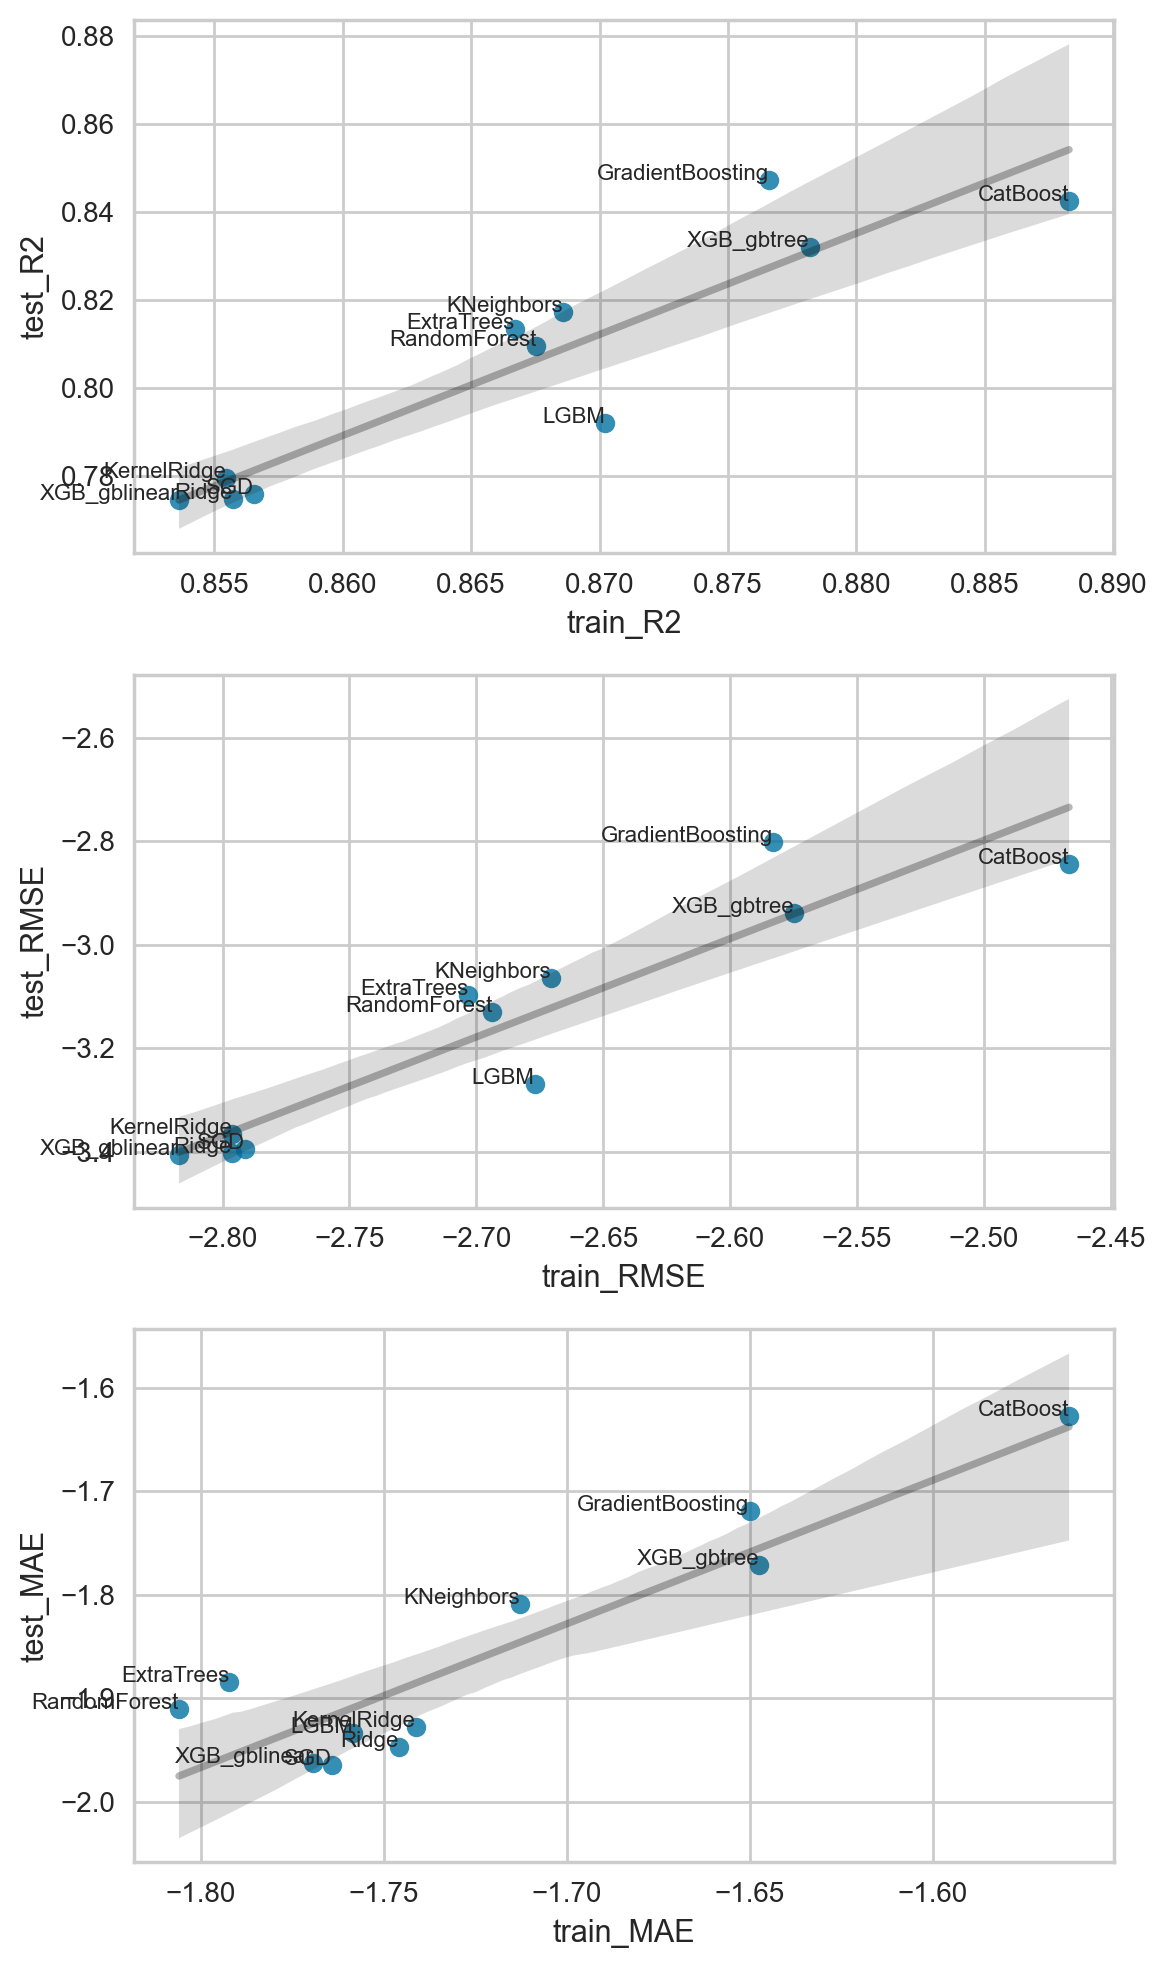

In [436]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(6,10), tight_layout=True, dpi=200)

sns.regplot(overfit, x='train_R2', y='test_R2', ax=ax1, 
            line_kws={'color':'k', 'alpha':0.3})
sns.regplot(-overfit, x='train_RMSE', y='test_RMSE', ax=ax2, 
            line_kws={'color':'k', 'alpha':0.3})
sns.regplot(-overfit, x='train_MAE', y='test_MAE', ax=ax3, 
            line_kws={'color':'k', 'alpha':0.3})

for val in overfit.index:
    ax1.text(overfit.loc[val,'train_R2'], overfit.loc[val,'test_R2'], 
             val.replace('Regressor',''), fontsize=8, ha='right')
    ax2.text(-overfit.loc[val,'train_RMSE'], -overfit.loc[val,'test_RMSE'], 
             val.replace('Regressor',''), fontsize=8, ha='right')
    ax3.text(-overfit.loc[val,'train_MAE'], -overfit.loc[val,'test_MAE'], 
             val.replace('Regressor',''), fontsize=8, ha='right')

plt.savefig(f'graphs/Model/overfitting_check.png', bbox_inches='tight')


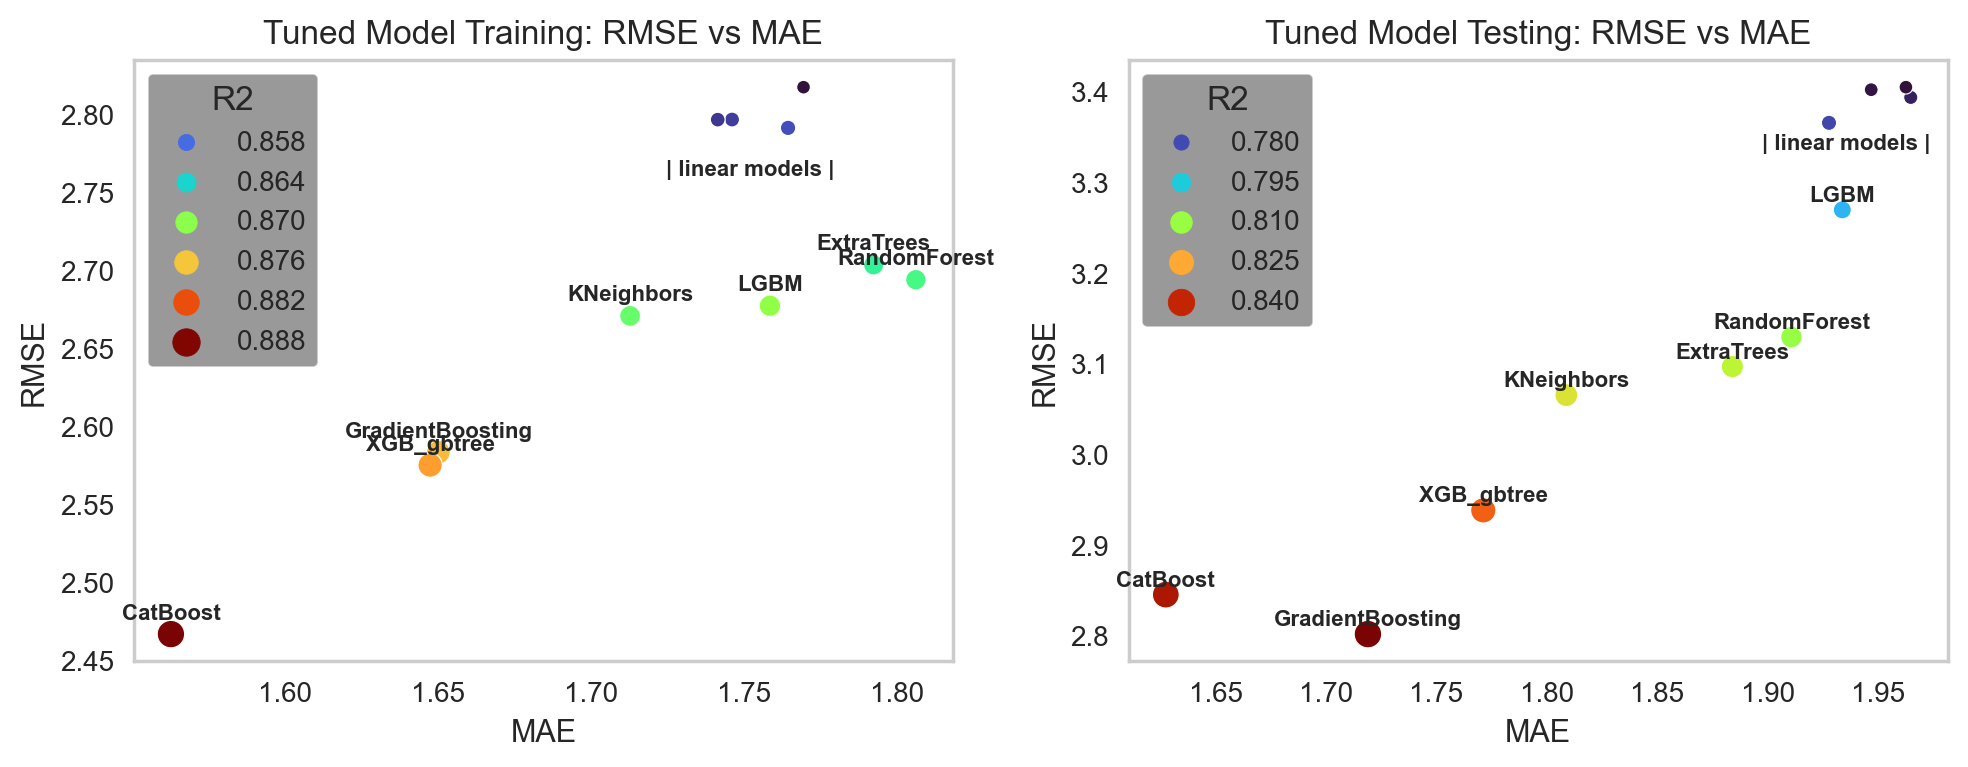

In [459]:
m1 = 'tuned_MAE'
m2 = 'tuned_RMSE'

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), tight_layout=True, dpi=200)


sns.scatterplot(cv_results, x=m1, y=m2, hue='tuned_R2', 
                palette='turbo', size='tuned_R2', ax=ax1)
for val in cv_results.sort_values([m2]).head(7).index:
    ax1.text(cv_results.loc[val,m1], cv_results.loc[val,m2]+.01,
             val.replace('Regressor',''),
             fontsize=8, fontweight='bold', ha='center')

ax1.text(cv_results[m1].max()*0.97, cv_results[m2].max()*.98, '| linear models |', 
         fontsize=8, fontweight='bold', ha='center')

ax1.legend(loc='upper left', title='R2', frameon=True, facecolor='grey')    
ax1.set_title(f"Tuned Model Training: {m2.replace('tuned_','')} vs {m1.replace('tuned_','')}")
ax1.set_xlabel(m1.replace('tuned_',''))
ax1.set_ylabel(m2.replace('tuned_',''))
ax1.grid()

sns.scatterplot(test_results, x=m1, y=m2, hue='tuned_R2', 
                palette='turbo', size='tuned_R2', ax=ax2)
for val in test_results.sort_values([m2]).head(7).index:
    ax2.text(test_results.loc[val,m1], test_results.loc[val,m2]+.01,
             val.replace('Regressor',''),
             fontsize=8, fontweight='bold', ha='center')

ax2.text(test_results[m1].max()*0.985, test_results[m2].max()*.98, '| linear models |', 
         fontsize=8, fontweight='bold', ha='center')

ax2.legend(loc='upper left', title='R2', frameon=True, facecolor='grey')    
ax2.set_title(f"Tuned Model Testing: {m2.replace('tuned_','')} vs {m1.replace('tuned_','')}")
ax2.set_xlabel(m1.replace('tuned_',''))
ax2.set_ylabel(m2.replace('tuned_',''))
ax2.grid()



plt.savefig(f"graphs/Model/model-selection_{m2.replace('tuned_','')}-vs-{m1.replace('tuned_','')}.png", bbox_inches='tight')
plt.show()

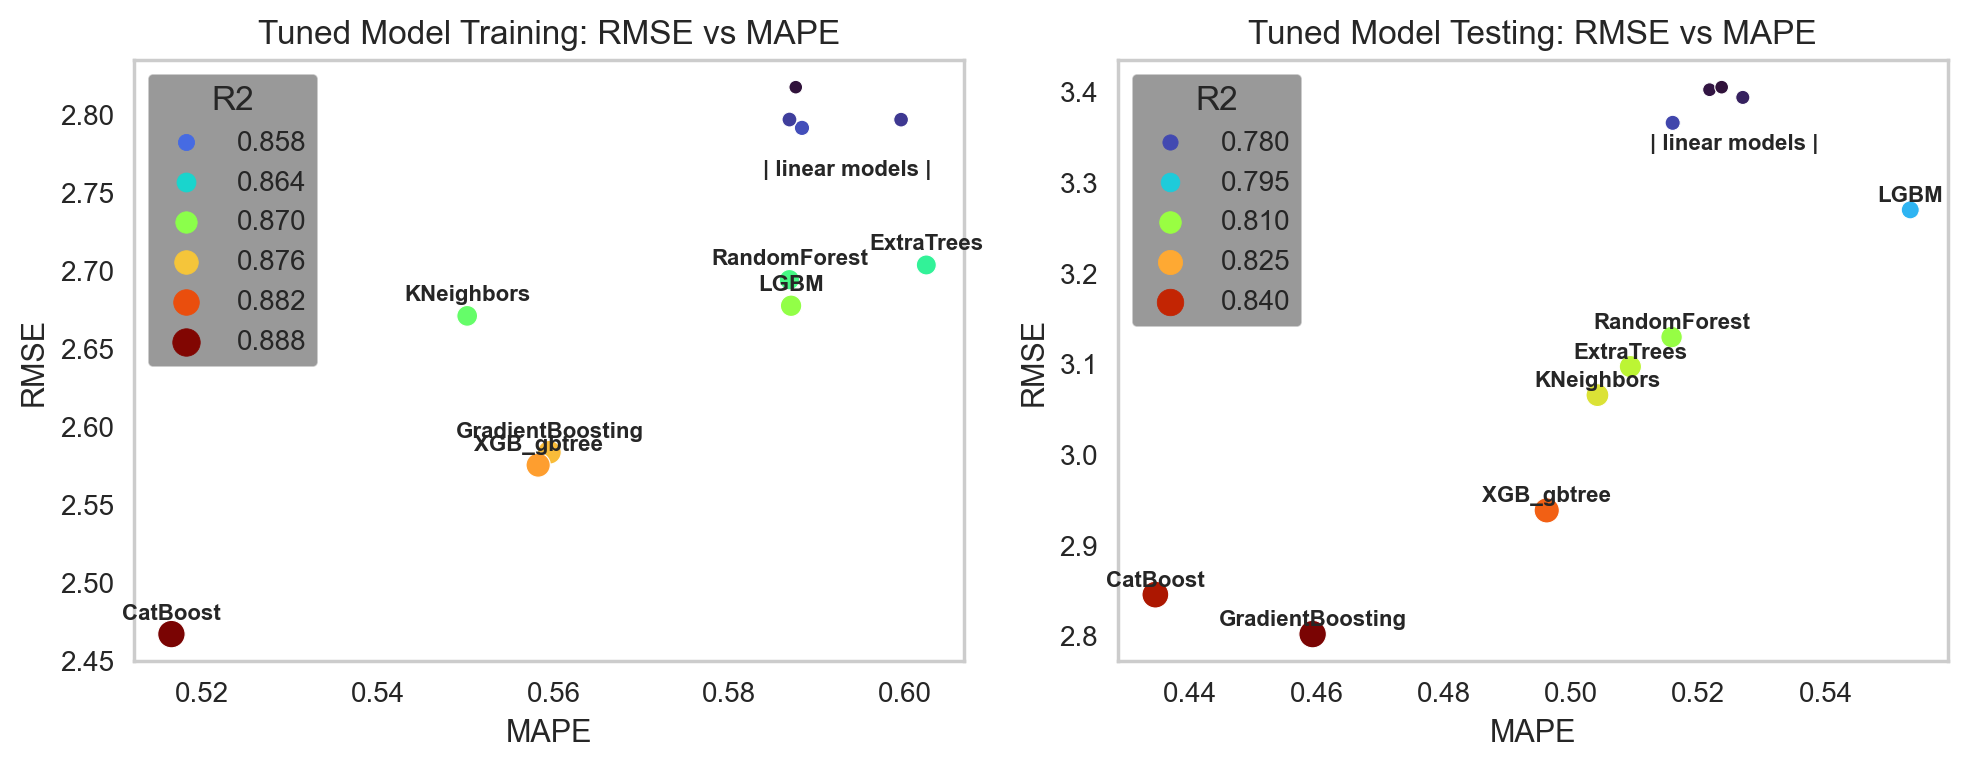

In [463]:
m1 = 'tuned_MAPE'
m2 = 'tuned_RMSE'

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), tight_layout=True, dpi=200)


sns.scatterplot(cv_results, x=m1, y=m2, hue='tuned_R2', 
                palette='turbo', size='tuned_R2', ax=ax1)
for val in cv_results.sort_values([m2]).head(7).index:
    ax1.text(cv_results.loc[val,m1], cv_results.loc[val,m2]+.01,
             val.replace('Regressor',''),
             fontsize=8, fontweight='bold', ha='center')

ax1.text(cv_results[m1].max()*0.985, cv_results[m2].max()*.98, '| linear models |', 
         fontsize=8, fontweight='bold', ha='center')

ax1.legend(loc='upper left', title='R2', frameon=True, facecolor='grey')    
ax1.set_title(f"Tuned Model Training: {m2.replace('tuned_','')} vs {m1.replace('tuned_','')}")
ax1.set_xlabel(m1.replace('tuned_',''))
ax1.set_ylabel(m2.replace('tuned_',''))
ax1.grid()

sns.scatterplot(test_results, x=m1, y=m2, hue='tuned_R2', 
                palette='turbo', size='tuned_R2', ax=ax2)
for val in test_results.sort_values([m2]).head(7).index:
    ax2.text(test_results.loc[val,m1], test_results.loc[val,m2]+.01,
             val.replace('Regressor',''),
             fontsize=8, fontweight='bold', ha='center')

ax2.text(test_results[m1].max()*0.95, test_results[m2].max()*.98, '| linear models |', 
         fontsize=8, fontweight='bold', ha='center')

ax2.legend(loc='upper left', title='R2', frameon=True, facecolor='grey')    
ax2.set_title(f"Tuned Model Testing: {m2.replace('tuned_','')} vs {m1.replace('tuned_','')}")
ax2.set_xlabel(m1.replace('tuned_',''))
ax2.set_ylabel(m2.replace('tuned_',''))
ax2.grid()



plt.savefig(f"graphs/Model/model-selection_{m2.replace('tuned_','')}-vs-{m1.replace('tuned_','')}.png", bbox_inches='tight')
plt.show()

---

#### Linear Tuning
*cells used to determine parameter grids and iterations*

**Notes**
 - try different probability distributions instead of varying ranges

In [462]:
tuning_grids = {
    'SGDRegressor': { 'iterations': 300, 'grid': {
        # leave loss function, penalty, learning_rate, fit_intercept at defaults: 'squared_error', 'L2', 'invscaling', True
        # vary alpha, tol(erance), eta0, power_t
        'alpha': loguniform(8e-5, 1e-2, 0, 1), # def=1e-4, float | higher values increase regularization strength
        'tol': loguniform(1e-5, 1e-2, 0, 1), # def=1e-3, float or None | convergence parameter
        'eta0': loguniform(1e-2, 8e-1, 0, 1), # def=0.01, float | initial learning rate
        'power_t': powerlaw(1, 0, 1), # def=0.25, float | exponent for invscaling learning rate: eta = eta0/pow(t, power_t)
    }},
    'Ridge': { 'iterations': 300, 'grid': {
        # vary alpha, tolerance/solver (see old sheet)
        'alpha': loguniform(0.01,10,0,1), # def=1, controls regularization strength [0,inf)
        'tol': loguniform(1e-2,0.95,0,1), # def=1e-4, specifies convergence critieria for solvers: sparse_cg, lsqr, sag, saga, lbfgs
        'solver':['saga'], # def='auto', previous grid search found good performance for saga, limit this search
    }},
    'KernelRidge': { 'iterations': 30, 'grid': {
        # vary alpha. if kernel is varied to something other than linear, then can also vary gamma
        'alpha': uniform(0,2), # def=1, controls regularization strength, must be positive float
        'kernel': ['linear'], # see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_kernels.html
    }},
    'KNeighborsRegressor': { 'iterations': 60, 'grid': {
        # vary n_neighbors, weights, algorithm (k-d vs ball tree), leaf_size (keep default), p [0,1]
        'n_neighbors': randint(2,9,0), # def=5, 
        'weights': ['uniform','distance'], # def='uniform', weight function used in prediction. uniform or distance based (inverse relation)
        'algorithm': ['ball_tree', 'kd_tree'], # def='auto', brute-force, kd_tree, ball_tree
        'leaf_size': nbinom(30,0.5,1),
        'p':[1,2],
    }},
}

In [463]:
sgd_pipe = make_pipeline(SelectKBest(score_func=f_regression, k=7), StandardScaler(), SGDRegressor(random_state=42))
ridge_pipe = make_pipeline(SelectKBest(score_func=f_regression, k=8), StandardScaler(), Ridge(random_state=42))
kr_pipe = make_pipeline(SelectKBest(score_func=f_regression, k=7), KernelRidge())
knn_pipe = make_pipeline(SelectKBest(score_func=f_regression, k=7), KNeighborsRegressor(n_jobs=-1))

In [464]:
%%time

test_results = pd.DataFrame()
cv_results = pd.DataFrame()
tuning_notes = {} # iterations, time taken, best parameters

for pipe in tqdm([sgd_pipe, ridge_pipe, kr_pipe, knn_pipe]):
    ind = pipe[-1].__class__.__name__
    
    # default score: validation set and CV scores
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    cv = cross_validate(pipe, X_train, y_train,
            scoring=['r2', 'neg_mean_absolute_error','neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error'],
                        cv=10, n_jobs=-1)

    # cv results
    cv_results.loc[ind,'def_R2'] = np.mean(cv['test_r2'])
    cv_results.loc[ind,'def_RMSE'] = -1*np.mean(cv['test_neg_root_mean_squared_error'])
    cv_results.loc[ind,'def_MAE'] = -1*np.mean(cv['test_neg_mean_absolute_error'])
    cv_results.loc[ind,'def_MAPE'] = -1*np.median(cv['test_neg_mean_absolute_percentage_error'])
    # baseline testing
    test_results.loc[ind,'def_R2'] = r2_score(y_test,y_pred)
    test_results.loc[ind,'def_RMSE'] = np.sqrt(mean_squared_error(y_test,y_pred))
    test_results.loc[ind,'def_MAE'] = mean_absolute_error(y_test,y_pred)
    test_results.loc[ind,'def_MAPE'] = mean_absolute_percentage_error(y_test,y_pred)
    
    # tuning scores, best model scores
    grid = {f'{ind.lower()}__{key}':val for key,val in tuning_grids[ind]['grid'].items()}
    
    start = time()
    search = RandomizedSearchCV(pipe, grid, n_iter=tuning_grids[ind]['iterations'],
                            scoring='r2', refit=True,  random_state=42, cv=10, n_jobs=-1)
    cv = search.fit(X_train,y_train)
    y_pred = cv.best_estimator_.predict(X_test)
    stop = round(time()-start,2)
    # record tuning notes
    tuning_notes[ind] = {}
    tuning_notes[ind]['iterations'] = tuning_grids[ind]['iterations']
    tuning_notes[ind]['time'] = stop
    tuning_notes[ind]['parameters'] = cv.best_params_
    
    cv = cross_validate(cv.best_estimator_, X_train, y_train,
            scoring=['r2', 'neg_mean_absolute_error','neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error'],
                        cv=10, n_jobs=-1)

    # tuned cv results
    cv_results.loc[ind,'tuned_R2'] = np.mean(cv['test_r2'])
    cv_results.loc[ind,'tuned_RMSE'] = -1*np.mean(cv['test_neg_root_mean_squared_error'])
    cv_results.loc[ind,'tuned_MAE'] = -1*np.mean(cv['test_neg_mean_absolute_error'])
    cv_results.loc[ind,'tuned_MAPE'] = -1*np.median(cv['test_neg_mean_absolute_percentage_error'])
    # tuned testing
    test_results.loc[ind,'tuned_R2'] = r2_score(y_test,y_pred)
    test_results.loc[ind,'tuned_RMSE'] = np.sqrt(mean_squared_error(y_test,y_pred))
    test_results.loc[ind,'tuned_MAE'] = mean_absolute_error(y_test,y_pred)
    test_results.loc[ind,'tuned_MAPE'] = mean_absolute_percentage_error(y_test,y_pred)   
    
    # tune/def test score ratio
    tuning_notes[ind]['factor'] = {
        'R2': cv_results.loc[ind,'tuned_R2'] / cv_results.loc[ind,'def_R2'],
        'RMSE' : cv_results.loc[ind,'tuned_RMSE'] / cv_results.loc[ind,'def_RMSE'],
        'MAE' : cv_results.loc[ind,'tuned_MAE'] / cv_results.loc[ind,'def_MAE'],
    }
    


100%|██████████| 4/4 [00:21<00:00,  5.42s/it]

CPU times: total: 10.2 s
Wall time: 21.7 s


In [231]:
cv_results.sort_values('tuned_R2', ascending=False).round(3)

,def_R2,def_RMSE,def_MAE,def_MAPE,tuned_R2,tuned_RMSE,tuned_MAE,tuned_MAPE
KNeighborsRegressor,0.863,2.621,1.664,0.496,0.868,2.571,1.644,0.479
Ridge,0.842,2.812,1.771,0.502,0.843,2.806,1.809,0.520
SGDRegressor,0.842,2.811,1.772,0.498,0.843,2.814,1.824,0.521
KernelRidge,0.843,2.806,1.762,0.507,0.843,2.804,1.764,0.506


In [232]:
tuning_notes

{'SGDRegressor': {'iterations': 300,
  'time': 9.27,
  'parameters': {'sgdregressor__alpha': 0.0035643859359643397,
   'sgdregressor__eta0': 0.014796438154354954,
   'sgdregressor__power_t': 0.41758077578492836,
   'sgdregressor__tol': 0.004338653054883512},
  'factor': {'R2': 1.0010116308996528,
   'RMSE': 1.0011858355098853,
   'MAE': 1.0292500377094709}},
 'Ridge': {'iterations': 300,
  'time': 4.21,
  'parameters': {'ridge__alpha': 0.014882513324386766,
   'ridge__solver': 'saga',
   'ridge__tol': 0.12212828045738938},
  'factor': {'R2': 1.001473299144266,
   'RMSE': 0.9979989294222243,
   'MAE': 1.0213160065036355}},
 'KernelRidge': {'iterations': 30,
  'time': 4.99,
  'parameters': {'kernelridge__alpha': 0.09290082543999545,
   'kernelridge__kernel': 'linear'},
  'factor': {'R2': 1.000273542926233,
   'RMSE': 0.9993722936886273,
   'MAE': 1.001348464341367}},
 'KNeighborsRegressor': {'iterations': 60,
  'time': 2.54,
  'parameters': {'kneighborsregressor__algorithm': 'kd_tree',
 

#### Ensemble Tuning
*cells used to determine parameter grids and iterations*

Notes
 - et stops improving after 90 (40s)
 - gbr stops improving after 60 (45s)
 - rf stops after 30 (25s)
 - LGBM stops improving after 30 (30s)
   - num_leaves, min_data stay close to defaults, vary in tight range. also learning_rate, n_iter
 - XGB - gblinear 60 fine, 3s
   - lambda (0) L2 reg, alpha(0) L1 reg, 
 - XGB - gbtree no improvement after 60, (23s)
   - start with eta (larning_rate), gamma (min_split_loss), max_depth | subsample, colsample_bytree
 - CatBoost varied improvement, 20 iterations good in 2 mins 
   - vary learning rate,L2 regularization, random strength | *leave depth at default to speed up RCV*

In [17]:
enemble_tuning_grids = {
    # vary estimators, keep criterion at squared_error (friedman can work well), vary min_samples_split
    'ExtraTreesRegressor': {'iterations': 90, 'grid': {
        'n_estimators':boltzmann(0.01,200,10),  
    }},
    # vary learning rate, n_estimators. keep loss function as huber
    'GradientBoostingRegressor': {'iterations': 60, 'grid': {
        'loss':['huber'],
        'learning_rate': loguniform(.04,1,0,1),
        'n_estimators': boltzmann(0.01,200,10),
    }},
    'RandomForestRegressor': {'iterations': 60, 'grid': {
        'n_estimators':boltzmann(0.01,200,10),  
        'max_features':binom(14,0.5,0),
    }},
    'LGBMRegressor': {'iterations': 30, 'grid': {
        'num_leaves': randint(25,36,0), # def=31
        'min_data_in_leaf': randint(15,25,0),  #def=20, not listed as parameter
        'learning_rate':loguniform(0.01,0.5,0,1), # def=0.1
        'n_estimators':randint(100,300,0), # def=100, not listed as a parameter | boltzmann(0.001,500,50)
    }},
    'CatBoostRegressor': {'iterations': 20, 'grid': {
        'l2_leaf_reg':uniform(0,4), # def=3
        'random_strength':uniform(0,3), # def=1
        'learning_rate':beta(2,20,0,1), # def=0.043
    }},
    # XGB - Linear Booster
    'XGBRegressor_gblinear': {'iterations': 60, 'grid': {
        'lambda':loguniform(.001,1,0,1), # def=0, L2 regularization
        'updater':['shotgun'], # def='shotgun', descent algorithm to fit linear model
        'feature_selector': ['cyclic'], # def='cyclic', feature selection and ordering method
    }},
    # XGB - Tree
    # complexity: max_depth, min_child_weight, gamma
    # randomness: subsample, colsample_bytree. reduce eta while increasing num_round
    'XGBRegressor_gbtree': {'iterations': 60, 'grid': {
        'eta':beta(2,4,0,1), # def=0.3, learning_rate. [0,1]
        'gamma': loguniform(0.001,1,0,1), # def=0, minimum loss reduction, larger=more conservative. [0,inf)
        'max_depth': randint(2,15,0), # def=6, higher increases chances to overfit, use with learning rate
        'subsample': uniform(0.6,0.4), # def=1, (0,1]. practically vary 0.5-1
        'colsample_bytree': uniform(0.6,0.4), # def=1, subsample ratio of columns used when constructing each tree 
    }},
}

In [18]:
gbr_pipe = make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=42, ))
et_pipe = make_pipeline(StandardScaler(), ExtraTreesRegressor(n_jobs=-1, random_state=42))
rf_pipe = make_pipeline(StandardScaler(), RandomForestRegressor(n_jobs=-1, random_state=42))
cat_pipe = make_pipeline(StandardScaler(), CatBoostRegressor(random_seed=42, verbose=False))
lgbm_pipe = make_pipeline(StandardScaler(), lgb.LGBMRegressor(n_jobs=-1, random_state=42, verbosity=-1))
xgb_tree_pipe = make_pipeline(StandardScaler(), xgb.XGBRegressor(booster="gbtree", ))
xgb_linear_pipe = make_pipeline(StandardScaler(), xgb.XGBRegressor(booster="gblinear", ))

In [19]:
%%time

test_results = pd.DataFrame()
cv_results = pd.DataFrame()
tuning_notes = {} # iterations, time taken, best parameters

for pipe in tqdm([cat_pipe, gbr_pipe, et_pipe, rf_pipe, lgbm_pipe, xgb_tree_pipe, xgb_linear_pipe]):
    ind = pipe[-1].__class__.__name__
    if ind == 'XGBRegressor':
        ind = f'{ind}_{pipe[-1].booster}'
    
    # default score: validation set and CV scores
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    cv = cross_validate(pipe, X_train, y_train,
            scoring=['r2', 'neg_mean_absolute_error','neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error'],
                        cv=10, n_jobs=-1)

    # cv results
    cv_results.loc[ind,'def_R2'] = np.mean(cv['test_r2'])
    cv_results.loc[ind,'def_RMSE'] = -1*np.mean(cv['test_neg_root_mean_squared_error'])
    cv_results.loc[ind,'def_MAE'] = -1*np.mean(cv['test_neg_mean_absolute_error'])
    cv_results.loc[ind,'def_MAPE'] = -1*np.median(cv['test_neg_mean_absolute_percentage_error'])
    # baseline testing
    test_results.loc[ind,'def_R2'] = r2_score(y_test,y_pred)
    test_results.loc[ind,'def_RMSE'] = np.sqrt(mean_squared_error(y_test,y_pred))
    test_results.loc[ind,'def_MAE'] = mean_absolute_error(y_test,y_pred)
    test_results.loc[ind,'def_MAPE'] = mean_absolute_percentage_error(y_test,y_pred)
    
    # tuning scores, best model scores
    if ind.startswith('XGBRegressor'):
        grid = {f'{pipe[-1].__class__.__name__.lower()}__{key}':val for key,val in enemble_tuning_grids[ind]['grid'].items()}
    else:
        grid = {f'{ind.lower()}__{key}':val for key,val in enemble_tuning_grids[ind]['grid'].items()}
    
    start = time()
    search = RandomizedSearchCV(pipe, grid, n_iter=enemble_tuning_grids[ind]['iterations'],
                            scoring='r2', refit=True,  random_state=42, cv=10, n_jobs=-1)
    cv = search.fit(X_train,y_train)
    y_pred = cv.best_estimator_.predict(X_test)
    stop = round(time()-start,2)
    # record tuning notes
    tuning_notes[ind] = {}
    tuning_notes[ind]['iterations'] = enemble_tuning_grids[ind]['iterations']
    tuning_notes[ind]['time'] = stop
    tuning_notes[ind]['parameters'] = cv.best_params_
    
    cv = cross_validate(cv.best_estimator_, X_train, y_train,
            scoring=['r2', 'neg_mean_absolute_error','neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error'],
                        cv=10, n_jobs=-1)

    # tuned cv results
    cv_results.loc[ind,'tuned_R2'] = np.mean(cv['test_r2'])
    cv_results.loc[ind,'tuned_RMSE'] = -1*np.mean(cv['test_neg_root_mean_squared_error'])
    cv_results.loc[ind,'tuned_MAE'] = -1*np.mean(cv['test_neg_mean_absolute_error'])
    cv_results.loc[ind,'tuned_MAPE'] = -1*np.median(cv['test_neg_mean_absolute_percentage_error'])
    # tuned testing
    test_results.loc[ind,'tuned_R2'] = r2_score(y_test,y_pred)
    test_results.loc[ind,'tuned_RMSE'] = np.sqrt(mean_squared_error(y_test,y_pred))
    test_results.loc[ind,'tuned_MAE'] = mean_absolute_error(y_test,y_pred)
    test_results.loc[ind,'tuned_MAPE'] = mean_absolute_percentage_error(y_test,y_pred)   
    
    # tune/def test score ratio
    tuning_notes[ind]['factor'] = {
        'R2': cv_results.loc[ind,'tuned_R2'] / cv_results.loc[ind,'def_R2'],
        'RMSE' : cv_results.loc[ind,'tuned_RMSE'] / cv_results.loc[ind,'def_RMSE'],
        'MAE' : cv_results.loc[ind,'tuned_MAE'] / cv_results.loc[ind,'def_MAE'],
    }
    


100%|██████████| 7/7 [05:36<00:00, 48.12s/it] 

CPU times: total: 51.6 s
Wall time: 5min 36s


In [459]:
test_results.sort_values('tuned_RMSE').round(3)

,def_R2,def_RMSE,def_MAE,def_MAPE,tuned_R2,tuned_RMSE,tuned_MAE,tuned_MAPE
GradientBoostingRegressor,0.864,2.865,1.830,9.122202e+13,0.875,2.748,1.739,1.036359e+14
CatBoostRegressor,0.866,2.849,1.613,1.219931e+14,0.875,2.749,1.614,1.347343e+14
ExtraTreesRegressor,0.857,2.945,1.845,1.200960e+14,0.857,2.941,1.833,1.177412e+14
RandomForestRegressor,0.841,3.100,1.913,1.875028e+14,0.855,2.964,1.846,1.396187e+14
XGBRegressor_gbtree,0.848,3.033,1.899,7.722359e+13,0.853,2.979,1.746,1.002675e+14
LGBMRegressor,0.841,3.104,1.892,1.279877e+14,0.828,3.221,1.954,1.443072e+14
XGBRegressor_gblinear,0.819,3.309,1.837,9.395783e+13,0.819,3.312,1.859,9.515463e+13


In [460]:
cv_results.sort_values('tuned_RMSE').round(3)

,def_R2,def_RMSE,def_MAE,def_MAPE,tuned_R2,tuned_RMSE,tuned_MAE,tuned_MAPE
CatBoostRegressor,0.884,2.479,1.552,0.501,0.885,2.463,1.538,0.485
GradientBoostingRegressor,0.854,2.780,1.794,0.554,0.873,2.595,1.651,0.516
XGBRegressor_gbtree,0.849,2.824,1.816,0.546,0.870,2.616,1.674,0.545
ExtraTreesRegressor,0.867,2.662,1.749,0.554,0.868,2.647,1.732,0.539
LGBMRegressor,0.861,2.728,1.762,0.550,0.864,2.686,1.734,0.530
RandomForestRegressor,0.842,2.896,1.881,0.601,0.865,2.687,1.771,0.535
XGBRegressor_gblinear,0.844,2.891,1.766,0.559,0.844,2.891,1.779,0.563


In [20]:
tuning_notes

{'CatBoostRegressor': {'iterations': 20,
  'time': 127.89,
  'parameters': {'catboostregressor__l2_leaf_reg': 1.49816047538945,
   'catboostregressor__learning_rate': 0.027804851956917426,
   'catboostregressor__random_strength': 2.5985284373248057},
  'factor': {'R2': 1.0027387918300659,
   'RMSE': 0.9903502819391528,
   'MAE': 0.9862609819866146}},
 'GradientBoostingRegressor': {'iterations': 60,
  'time': 35.61,
  'parameters': {'gradientboostingregressor__learning_rate': 0.13355022016523652,
   'gradientboostingregressor__loss': 'huber',
   'gradientboostingregressor__n_estimators': 182},
  'factor': {'R2': 1.0124229108618301,
   'RMSE': 0.9528274303477378,
   'MAE': 0.9205879916286418}},
 'ExtraTreesRegressor': {'iterations': 90,
  'time': 39.64,
  'parameters': {'extratreesregressor__n_estimators': 201},
  'factor': {'R2': 1.002717476083396,
   'RMSE': 0.9919084780393377,
   'MAE': 0.9946430627806063}},
 'RandomForestRegressor': {'iterations': 60,
  'time': 39.72,
  'parameters':

In [294]:
cat_pipe[1].get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 0,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'lear

In [297]:
for model in [
    CatBoostRegressor, lgb.LGBMRegressor, RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor,
    xgb.XGBRegressor,
              ]:
    print(model.__name__)

CatBoostRegressor
LGBMRegressor
RandomForestRegressor
GradientBoostingRegressor
ExtraTreesRegressor
XGBRegressor


### Test Outlier Detection
 - **not helpful, ideally would study within pipeline . . .**
   - manually tested effect of outlier removal (CV score before, CV score after)
     - most metrics for all models worse, kNN error decreases slightly
   - issues with integrating Outlier Detection into pipeline
     - custom TransformerMixin class
     - imblearn package


In [28]:
tuning_grids = {
    'KNeighborsRegressor': { 'iterations': 60, 'grid': {
        # vary n_neighbors, weights, algorithm (k-d vs ball tree), leaf_size (keep default), p [0,1]
        'n_neighbors': randint(2,9,0), # def=5, 
        'weights': ['uniform','distance'], # def='uniform', weight function used in prediction. uniform or distance based (inverse relation)
        'algorithm': ['ball_tree', 'kd_tree'], # def='auto', brute-force, kd_tree, ball_tree
        'leaf_size': nbinom(30,0.5,1),
        'p':[1,2],
    }},
    # vary learning rate, n_estimators. keep loss function as huber
    'GradientBoostingRegressor': {'iterations': 60, 'grid': {
        'loss':['huber'],
        'learning_rate': loguniform(.04,1,0,1),
        'n_estimators': boltzmann(0.01,200,10),
    }},
    'CatBoostRegressor': {'iterations': 20, 'grid': {
        'l2_leaf_reg':uniform(0,4), # def=3
        'random_strength':uniform(0,3), # def=1
        'learning_rate':beta(2,20,0,1), # def=0.043
    }},
    'XGBRegressor': {'iterations': 60, 'grid': {
        'eta':beta(2,4,0,1), # def=0.3, learning_rate. [0,1]
        'gamma': loguniform(0.001,1,0,1), # def=0, minimum loss reduction, larger=more conservative. [0,inf)
        'max_depth': randint(2,15,0), # def=6, higher increases chances to overfit, use with learning rate
        'subsample': uniform(0.6,0.4), # def=1, (0,1]. practically vary 0.5-1
        'colsample_bytree': uniform(0.6,0.4), # def=1, subsample ratio of columns used when constructing each tree 
    }},
}

In [29]:
# top model pipelines
knn_pipe = make_pipeline(SelectKBest(score_func=f_regression, k=7), KNeighborsRegressor(n_jobs=-1))
gbr_pipe = make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=42, ))
cat_pipe = make_pipeline(StandardScaler(), CatBoostRegressor(random_seed=42, verbose=False))
xgb_tree_pipe = make_pipeline(StandardScaler(), xgb.XGBRegressor(booster="gbtree", ))

*feature names warning can be ignored, see [here](https://github.com/scikit-learn/scikit-learn/issues/25844)*

In [30]:
import warnings
warnings.filterwarnings("ignore")

In [31]:
%%time

cv_results = pd.DataFrame()

for pipe in tqdm([ knn_pipe, cat_pipe, gbr_pipe, xgb_tree_pipe]):
    
    ind = pipe[-1].__class__.__name__
    
    # tuned baseline
    grid = {f'{ind.lower()}__{key}':val 
            for key,val in tuning_grids[ind]['grid'].items()}   
    
    search = RandomizedSearchCV(pipe, grid, n_iter=tuning_grids[ind]['iterations'],
                            scoring='r2', refit=True,  random_state=42, cv=10, n_jobs=-1)
    cv = search.fit(X_train,y_train)
    cv = cross_validate(cv.best_estimator_, X_train, y_train,
            scoring=['r2', 'neg_mean_absolute_error','neg_root_mean_squared_error', 
                     'neg_mean_absolute_percentage_error'],
                        cv=10, n_jobs=-1)
    cv_results.loc[ind,'tuned_R2'] = np.mean(cv['test_r2'])
    cv_results.loc[ind,'tuned_RMSE'] = -1*np.mean(cv['test_neg_root_mean_squared_error'])
    cv_results.loc[ind,'tuned_MAE'] = -1*np.mean(cv['test_neg_mean_absolute_error'])
    cv_results.loc[ind,'tuned_MAPE'] = -1*np.median(cv['test_neg_mean_absolute_percentage_error'])    
    
    # try removing outliers and do it again
    iso_forest = IsolationForest(contamination=0.01, random_state=42)
    iso_forest.fit(X_train)
    detection = pd.Series(iso_forest.predict(X_train), index=X_train.index)
    inliers = detection[detection==1].index
    
    cv = search.fit(X_train.loc[inliers,:], y_train[inliers])
    cv = cross_validate(cv.best_estimator_, X_train, y_train,
            scoring=['r2', 'neg_mean_absolute_error','neg_root_mean_squared_error', 
                     'neg_mean_absolute_percentage_error'],
                        cv=10, n_jobs=-1)
    ind = f'{ind}_outliers_removed'
    cv_results.loc[ind,'tuned_R2'] = np.mean(cv['test_r2'])
    cv_results.loc[ind,'tuned_RMSE'] = -1*np.mean(cv['test_neg_root_mean_squared_error'])
    cv_results.loc[ind,'tuned_MAE'] = -1*np.mean(cv['test_neg_mean_absolute_error'])
    cv_results.loc[ind,'tuned_MAPE'] = -1*np.median(cv['test_neg_mean_absolute_percentage_error'])        

100%|██████████| 4/4 [06:20<00:00, 95.08s/it] 

CPU times: total: 41.6 s
Wall time: 6min 20s


In [32]:
cv_results.sort_values('tuned_R2', ascending=False).round(3)

,tuned_R2,tuned_RMSE,tuned_MAE,tuned_MAPE
CatBoostRegressor,0.888,2.466,1.563,0.517
CatBoostRegressor_outliers_removed,0.885,2.510,1.590,0.530
XGBRegressor,0.878,2.575,1.647,0.558
GradientBoostingRegressor,0.877,2.583,1.650,0.560
GradientBoostingRegressor_outliers_removed,0.873,2.623,1.669,0.569
KNeighborsRegressor,0.869,2.670,1.713,0.550
KNeighborsRegressor_outliers_removed,0.868,2.671,1.693,0.538
XGBRegressor_outliers_removed,0.864,2.721,1.733,0.580


### Top Model Blending
   - **voting regressor (GBR + CatBoost) is best model**
     - stack/blend issues:
       - could not blend/stack pipelines, issues with SelectKBest and StandardScaler
         - could not include kNN due to different preprocessing
       - tried CatBoost+GBR, CatBoost+GBR+XGB(tree)

In [3]:
tuning_grids = {
    'KNeighborsRegressor': { 'iterations': 60, 'grid': {
        # vary n_neighbors, weights, algorithm (k-d vs ball tree), leaf_size (keep default), p [0,1]
        'n_neighbors': randint(2,9,0), # def=5, 
        'weights': ['uniform','distance'], # def='uniform', weight function used in prediction. uniform or distance based (inverse relation)
        'algorithm': ['ball_tree', 'kd_tree'], # def='auto', brute-force, kd_tree, ball_tree
        'leaf_size': nbinom(30,0.5,1),
        'p':[1,2],
    }},
    # vary learning rate, n_estimators. keep loss function as huber
    'GradientBoostingRegressor': {'iterations': 60, 'grid': {
        'loss':['huber'],
        'learning_rate': loguniform(.04,1,0,1),
        'n_estimators': boltzmann(0.01,200,10),
    }},
    'CatBoostRegressor': {'iterations': 20, 'grid': {
        'l2_leaf_reg':uniform(0,4), # def=3
        'random_strength':uniform(0,3), # def=1
        'learning_rate':beta(2,20,0,1), # def=0.043
    }},
    'XGBRegressor': {'iterations': 60, 'grid': {
        'eta':beta(2,4,0,1), # def=0.3, learning_rate. [0,1]
        'gamma': loguniform(0.001,1,0,1), # def=0, minimum loss reduction, larger=more conservative. [0,inf)
        'max_depth': randint(2,15,0), # def=6, higher increases chances to overfit, use with learning rate
        'subsample': uniform(0.6,0.4), # def=1, (0,1]. practically vary 0.5-1
        'colsample_bytree': uniform(0.6,0.4), # def=1, subsample ratio of columns used when constructing each tree 
    }},
}

In [4]:
# top 3 model pipelines
knn_pipe = Pipeline([('kbst', SelectKBest(score_func=f_regression, k=7)),
                     ('KNeighborsRegressor', KNeighborsRegressor(n_jobs=-1))])
gbr_pipe = Pipeline([('norm',StandardScaler()),
                     ('GradientBoostingRegressor', GradientBoostingRegressor(random_state=42, ))])
cat_pipe = Pipeline([('norm', StandardScaler()), 
                     ('CatBoostRegressor', CatBoostRegressor(random_seed=42, verbose=False))])
xgb_pipe = Pipeline([('norm',StandardScaler()),
                     ('XGBRegressor',xgb.XGBRegressor(booster="gbtree"))])

top = [knn_pipe, gbr_pipe, cat_pipe, xgb_pipe]

In [5]:
%%time

test_results = pd.DataFrame()
cv_results = pd.DataFrame()
top_tuned = []
model_params = {}

for pipe in tqdm(top):
    
    ind = pipe[-1].__class__.__name__
    
    # tune hyperparameters
    grid = {f'{ind}__{key}':val 
            for key,val in tuning_grids[ind]['grid'].items()}
    search = RandomizedSearchCV(pipe, grid, n_iter=tuning_grids[ind]['iterations'],
                            scoring='r2', refit=True,  random_state=42, cv=10, n_jobs=-1)
    cv = search.fit(X_train,y_train)
    
    # make predictions, record final parameters
    tuned = cv.best_estimator_
    tuned.fit(X_train,y_train)
    y_pred = tuned.predict(X_test)
    model_params[ind] = cv.best_params_
    
    # cross-validate
    top_tuned.append(tuned)
    cv = cross_validate(cv.best_estimator_, X_train, y_train,
            scoring=['r2', 'neg_mean_absolute_error','neg_root_mean_squared_error', 
                     'neg_mean_absolute_percentage_error'],
                        cv=10, n_jobs=-1)

    # train results
    cv_results.loc[ind,'R2'] = np.mean(cv['test_r2'])
    cv_results.loc[ind,'RMSE'] = -1*np.mean(cv['test_neg_root_mean_squared_error'])
    cv_results.loc[ind,'MAE'] = -1*np.mean(cv['test_neg_mean_absolute_error'])
    cv_results.loc[ind,'MAPE'] = -1*np.median(cv['test_neg_mean_absolute_percentage_error'])

    # test results
    test_results.loc[ind,'R2'] = r2_score(y_test,y_pred)
    test_results.loc[ind,'RMSE'] = np.sqrt(mean_squared_error(y_test,y_pred))
    test_results.loc[ind,'MAE'] = mean_absolute_error(y_test,y_pred)
    test_results.loc[ind,'MAPE'] = mean_absolute_percentage_error(y_test,y_pred) 
    
    

100%|██████████| 4/4 [03:14<00:00, 48.65s/it]

CPU times: total: 39.5 s
Wall time: 3min 14s


In [478]:
test_results.sort_values('R2', ascending=False).style\
    .background_gradient(subset='R2', cmap='viridis')\
    .background_gradient(subset=['RMSE', 'MAE', 'MAPE'], cmap='viridis_r')\
    .format('{:.3f}')

,R2,RMSE,MAE,MAPE
GradientBoostingRegressor,0.847,2.801,1.719,0.459
CatBoostRegressor,0.843,2.845,1.627,0.435
XGBRegressor,0.832,2.938,1.771,0.496
KNeighborsRegressor,0.817,3.065,1.809,0.504


In [479]:
cv_results.sort_values('R2', ascending=False).style\
    .background_gradient(subset='R2', cmap='viridis')\
    .background_gradient(subset=['RMSE', 'MAE', 'MAPE'], cmap='viridis_r')\
    .format('{:.3f}')

,R2,RMSE,MAE,MAPE
CatBoostRegressor,0.888,2.466,1.563,0.517
XGBRegressor,0.878,2.575,1.647,0.558
GradientBoostingRegressor,0.877,2.583,1.650,0.560
KNeighborsRegressor,0.869,2.670,1.713,0.550


In [11]:
model_params

{'KNeighborsRegressor': {'KNeighborsRegressor__algorithm': 'kd_tree',
  'KNeighborsRegressor__leaf_size': 34,
  'KNeighborsRegressor__n_neighbors': 7,
  'KNeighborsRegressor__p': 2,
  'KNeighborsRegressor__weights': 'distance'},
 'GradientBoostingRegressor': {'GradientBoostingRegressor__learning_rate': 0.13355022016523652,
  'GradientBoostingRegressor__loss': 'huber',
  'GradientBoostingRegressor__n_estimators': 182},
 'CatBoostRegressor': {'CatBoostRegressor__l2_leaf_reg': 1.49816047538945,
  'CatBoostRegressor__learning_rate': 0.027804851956917426,
  'CatBoostRegressor__random_strength': 2.5985284373248057},
 'XGBRegressor': {'XGBRegressor__colsample_bytree': 0.7181162353675755,
  'XGBRegressor__eta': 0.2894966808967191,
  'XGBRegressor__gamma': 0.018169482974997143,
  'XGBRegressor__max_depth': 3,
  'XGBRegressor__subsample': 0.9468289274320415}}

In [13]:
%%time

blend3 = VotingRegressor([
    ('gbr',top_tuned[1][-1]), ('catboost',top_tuned[2][-1]), ('xgb',top_tuned[3][-1]),
])
pipe_blend3 = Pipeline([('norm', StandardScaler()), ('vr', blend3)])
cv = cross_validate(pipe_blend3, X_train, y_train,
        scoring=['r2', 'neg_mean_absolute_error','neg_root_mean_squared_error', 
                 'neg_mean_absolute_percentage_error'],
                    cv=10, n_jobs=-1)

ind = 'voting_GBR-Cat-XGB'
# train results
cv_results.loc[ind,'R2'] = np.mean(cv['test_r2'])
cv_results.loc[ind,'RMSE'] = -1*np.mean(cv['test_neg_root_mean_squared_error'])
cv_results.loc[ind,'MAE'] = -1*np.mean(cv['test_neg_mean_absolute_error'])
cv_results.loc[ind,'MAPE'] = -1*np.median(cv['test_neg_mean_absolute_percentage_error'])

pipe_blend3.fit(X_train,y_train)

y_pred = pipe_blend3.predict(X_test)
# test results
test_results.loc[ind,'R2'] = r2_score(y_test,y_pred)
test_results.loc[ind,'RMSE'] = np.sqrt(mean_squared_error(y_test,y_pred))
test_results.loc[ind,'MAE'] = mean_absolute_error(y_test,y_pred)
test_results.loc[ind,'MAPE'] = mean_absolute_percentage_error(y_test,y_pred) 

CPU times: total: 15.5 s
Wall time: 10.7 s


In [15]:
%%time

blend2 = VotingRegressor([
    ('gbr',top_tuned[1][-1]), ('catboost',top_tuned[2][-1]),
])
pipe_blend2 = Pipeline([('norm', StandardScaler()), ('vr', blend2)])
cv = cross_validate(pipe_blend2, X_train, y_train,
        scoring=['r2', 'neg_mean_absolute_error','neg_root_mean_squared_error', 
                 'neg_mean_absolute_percentage_error'],
                    cv=10, n_jobs=-1)

ind = 'voting_GBR-Cat'
# train results
cv_results.loc[ind,'R2'] = np.mean(cv['test_r2'])
cv_results.loc[ind,'RMSE'] = -1*np.mean(cv['test_neg_root_mean_squared_error'])
cv_results.loc[ind,'MAE'] = -1*np.mean(cv['test_neg_mean_absolute_error'])
cv_results.loc[ind,'MAPE'] = -1*np.median(cv['test_neg_mean_absolute_percentage_error'])

pipe_blend2.fit(X_train,y_train)

y_pred = pipe_blend2.predict(X_test)
# test results
test_results.loc[ind,'R2'] = r2_score(y_test,y_pred)
test_results.loc[ind,'RMSE'] = np.sqrt(mean_squared_error(y_test,y_pred))
test_results.loc[ind,'MAE'] = mean_absolute_error(y_test,y_pred)
test_results.loc[ind,'MAPE'] = mean_absolute_percentage_error(y_test,y_pred) 

CPU times: total: 14.7 s
Wall time: 10 s


**Voting Regressor bleding GradientBoosting + CatBoost regressors improves over performance of CatBoost alone**

*MAE, MAPE slightly worse than CatBoost but R2 and RMSE both improve*

In [16]:
test_results.sort_values('R2', ascending=False).style\
    .background_gradient(subset='R2', cmap='viridis')\
    .background_gradient(subset=['RMSE', 'MAE', 'MAPE'], cmap='viridis_r')\
    .format('{:.3f}')

,R2,RMSE,MAE,MAPE
voting_GBR-Cat,0.849,2.789,1.644,0.438
GradientBoostingRegressor,0.847,2.801,1.719,0.459
voting_GBR-Cat-XGB,0.847,2.809,1.663,0.449
CatBoostRegressor,0.843,2.845,1.627,0.435
XGBRegressor,0.832,2.938,1.771,0.496
KNeighborsRegressor,0.817,3.065,1.809,0.504


In [17]:
cv_results.sort_values('R2', ascending=False).style\
    .background_gradient(subset='R2', cmap='viridis')\
    .background_gradient(subset=['RMSE', 'MAE', 'MAPE'], cmap='viridis_r')\
    .format('{:.3f}')

,R2,RMSE,MAE,MAPE
CatBoostRegressor,0.888,2.466,1.563,0.517
voting_GBR-Cat-XGB,0.886,2.485,1.576,0.532
voting_GBR-Cat,0.885,2.492,1.581,0.527
XGBRegressor,0.878,2.575,1.647,0.558
GradientBoostingRegressor,0.877,2.583,1.650,0.560
KNeighborsRegressor,0.869,2.670,1.713,0.550


In [621]:
test_results.to_csv('final models test set.csv')
cv_results.to_csv('final models train set.csv')

In [5]:
doc_df = pd.read_csv('final_model_info.csv', index_col=0)

In [6]:
doc_df

,Value
--,Overview
data size,1521
data split,8:2
normalization,"StandardScaler, (zscore)"
Features,12
Target Feature,home_margin
final model,VotingRegressor: GradientBoostingRegressor + C...
---,Test Scores
R2,0.8487202573537572
RMSE,2.7887955474285753


**Final Model Blend (GBR+CatBoost) has best performance**

*persist for local use, will not publish to repository. model information published [here](https://github.com/NBPub/Springboard/blob/main/Capstone%20Two/final_model_info.csv)*

In [570]:
pipe_blend2

Pipeline(steps=[('norm', StandardScaler()),
                ('vr',
                 VotingRegressor(estimators=[('gbr',
                                              GradientBoostingRegressor(learning_rate=0.13355022016523652,
                                                                        loss='huber',
                                                                        n_estimators=182,
                                                                        random_state=42)),
                                             ('catboost',
                                              <catboost.core.CatBoostRegressor object at 0x0000026A3E4DC5E0>)]))])

In [72]:
final = pipe_blend2

In [573]:
dump(final, 'final_model.joblib')

['final_model.joblib']

#### Model Metrics Submission

In [73]:
docs = final[1].get_params()

In [74]:
docs.pop('estimators')

[('gbr',
  GradientBoostingRegressor(learning_rate=0.13355022016523652, loss='huber',
                            n_estimators=182, random_state=42)),
 ('catboost', <catboost.core.CatBoostRegressor at 0x26dc08a20e0>)]

In [75]:
doc_df = pd.DataFrame(columns=['Value'])
doc_df.loc['--','Value'] = 'Overview'
doc_df.loc['data size','Value'] = f'{data.shape[0]}'
doc_df.loc['data split','Value'] = '8:2'
doc_df.loc['normalization','Value'] = 'StandardScaler, zscore'
doc_df.loc['Features','Value'] = len(features)
doc_df.loc['Target Feature','Value'] = 'home_margin'
doc_df.loc['final model','Value'] = 'VotingRegressor: GradientBoostingRegressor + CatBoostRegressor Blend'

doc_df.loc['---','Value'] = 'Test Scores'
for met in test_results.loc['voting_GBR-Cat'].index:
    doc_df.loc[met,'Value'] = test_results.loc['voting_GBR-Cat',met]

doc_df.loc['----','Value'] = 'Hyperparameters'
for key,val in docs.items():
    doc_df.loc[key,'Value'] = str(val)

In [76]:
doc_df.to_csv('final_model_info.csv')

### Best Model + Resiudal Analysis

In [3]:
# load from file or create above
final = load('final_model.joblib')

In [4]:
final

Pipeline(steps=[('norm', StandardScaler()),
                ('vr',
                 VotingRegressor(estimators=[('gbr',
                                              GradientBoostingRegressor(learning_rate=0.13355022016523652,
                                                                        loss='huber',
                                                                        n_estimators=182,
                                                                        random_state=42)),
                                             ('catboost',
                                              <catboost.core.CatBoostRegressor object at 0x00000291A9A9F0A0>)]))])

#### Learning Curve
- try with just X_train, then with all X

In [5]:
from sklearn.model_selection import learning_curve

In [23]:
fractions = [0.1, 0.4, 0.5, 0.8, 0.87, 0.95, 1.0]
# scoring options: 'r2', 'neg_mean_absolute_error','neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error'
# default: [0.1, 0.33, 0.55, 0.78, 1.], but amounts to ~ 0.09, 0.29, 0.49, 0.70, 0.90]

In [16]:
%%time
train_size, train_scores, test_scores = learning_curve(final, X, y, cv=10, train_sizes=fractions,
                                                       scoring='r2', n_jobs=-1,)
# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)

CPU times: total: 328 ms
Wall time: 37.3 s


In [27]:
train_size, train_scores, test_scores = learning_curve(final, X, y, cv=10, train_sizes=fractions,
                                                       scoring='r2', n_jobs=-1,)

lc_scores = pd.DataFrame([np.mean(test_scores, axis=1), np.std(test_scores, axis=1), np.mean(train_scores, axis=1), np.std(train_scores, axis=1)]).T
lc_scores.columns = ['test', 'test_std', 'train', 'train_std']
lc_scores.index = train_size
lc_scores

,test,test_std,train,train_std
136,0.733784,0.099626,0.998974,0.000285
547,0.851317,0.151136,0.990413,0.001814
684,0.854142,0.152376,0.986951,0.002109
1094,0.869725,0.164114,0.979134,0.002962
1231,0.872471,0.163647,0.978384,0.002815
1368,0.870596,0.172896,0.977001,0.002827


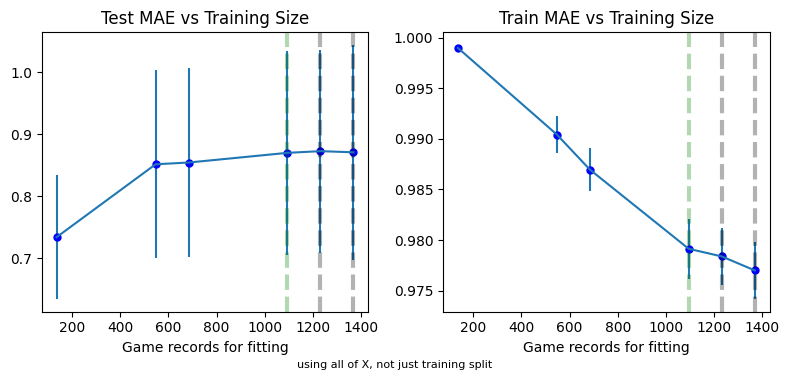

In [34]:
learning_curve_plot(lc_scores, metric)

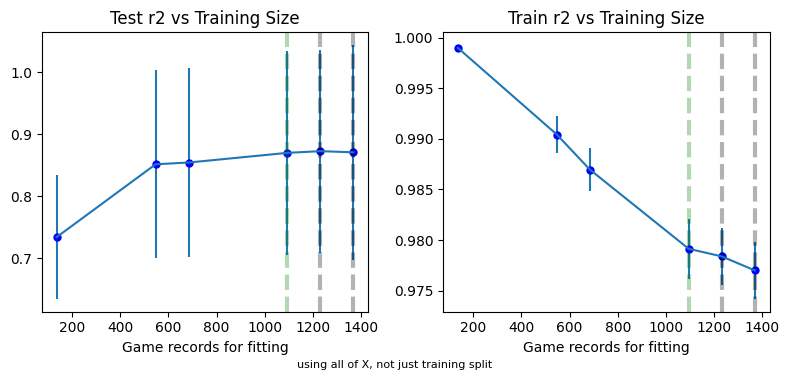

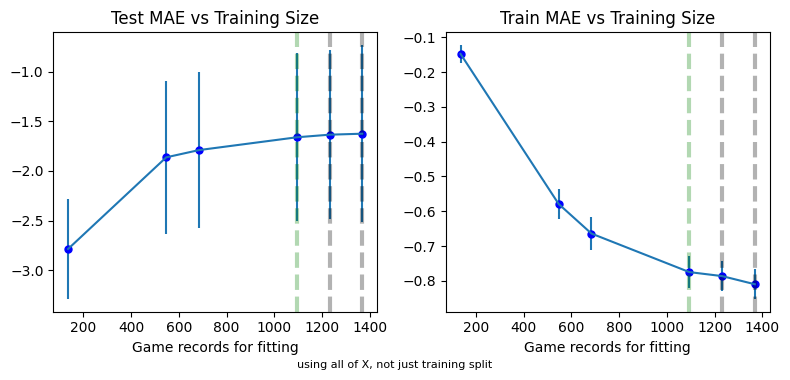

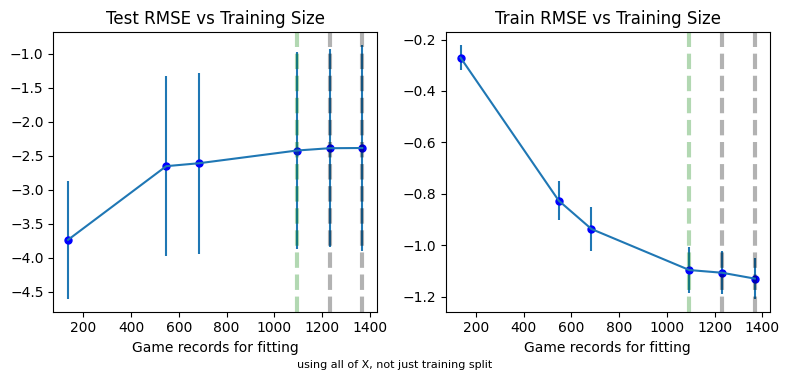

CPU times: total: 3.95 s
Wall time: 2min 10s


In [35]:
%%time

for metric in ['r2','neg_mean_absolute_error', 'neg_root_mean_squared_error']:
    train_size, train_scores, test_scores = learning_curve(final, X, y, cv=10, train_sizes=fractions,
                                                           scoring=metric, n_jobs=-1,)
    lc_scores = pd.DataFrame([np.mean(test_scores, axis=1), np.std(test_scores, axis=1), np.mean(train_scores, axis=1), np.std(train_scores, axis=1)]).T
    lc_scores.columns = ['test', 'test_std', 'train', 'train_std']
    lc_scores.index = train_size
    
    learning_curve_plot(lc_scores, metric)
    

In [17]:
lc_scores = pd.DataFrame([np.mean(test_scores, axis=1), np.std(test_scores, axis=1), np.mean(train_scores, axis=1), np.std(train_scores, axis=1)]).T
lc_scores.columns = ['test', 'test_std', 'train', 'train_std']
lc_scores.index = train_size

In [20]:
(train_size/X.shape[0])

array([0.08941486, 0.29191321, 0.49441157, 0.69690993, 0.89940828])

In [21]:
lc_scores

,test,test_std,train,train_std
136,0.733784,0.099626,0.998974,0.000285
444,0.841418,0.147600,0.992227,0.001457
752,0.856480,0.155607,0.985315,0.002069
1060,0.867327,0.165136,0.979834,0.002692
1368,0.870596,0.172896,0.977001,0.002827


In [33]:
def learning_curve_plot(df, metric):
    
    if metric == 'neg_mean_absolute_error':
        metric = 'MAE'
    elif metric == 'neg_root_mean_squared_error':
        metric = 'RMSE'
        
    inds = df.index[-3:]

    plt.figure(figsize=(8,4), tight_layout=True)
    plt.subplot(121)
    plt.errorbar(lc_scores.index, lc_scores['test'], yerr=lc_scores['test_std'])
    plt.plot(lc_scores.index, lc_scores['test'], 'b.', markersize=10)
    yb = plt.ylim()
    plt.plot([inds[0]]*2, yb, 'g--', alpha=0.3, linewidth=3)
    plt.plot([inds[1]]*2, yb, 'k--', alpha=0.3, linewidth=3)
    plt.plot([inds[2]]*2, yb, 'k--', alpha=0.3, linewidth=3)
    plt.ylim(yb)
    plt.title(f'Test {metric} vs Training Size')
    plt.xlabel('Game records for fitting')

    plt.subplot(122)
    plt.errorbar(lc_scores.index, lc_scores['train'], yerr=lc_scores['train_std'])
    plt.plot(lc_scores.index, lc_scores['train'], 'b.', markersize=10)
    yb = plt.ylim()
    plt.plot([inds[0]]*2, yb, 'g--', alpha=0.3, linewidth=3)
    plt.plot([inds[1]]*2, yb, 'k--', alpha=0.3, linewidth=3)
    plt.plot([inds[2]]*2, yb, 'k--', alpha=0.3, linewidth=3)
    plt.ylim(yb)
    plt.title(f'Train {metric} vs Training Size')
    plt.xlabel('Game records for fitting')
    plt.suptitle('using all of X, not just training split', fontsize=8, y=0.025, ha='center')
    plt.savefig(f'graphs/Model/learning_curve-{metric}.png', dpi=200)
    plt.show()

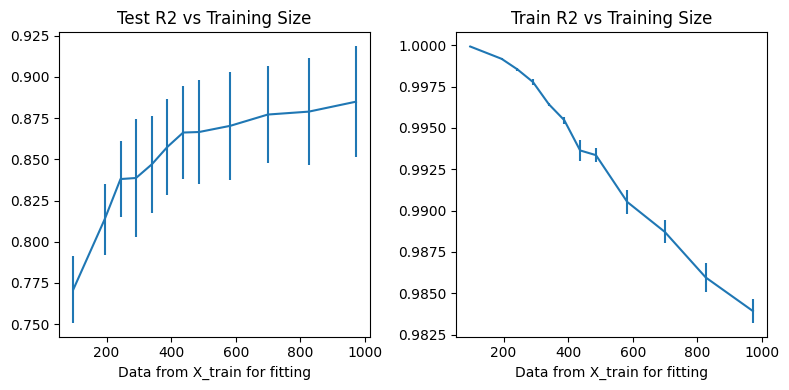

In [40]:
plt.figure(figsize=(8,4), tight_layout=True)
plt.subplot(121)
plt.errorbar(lc_scores.index, lc_scores['test'], yerr=lc_scores['test_std'])
plt.title('Test R2 vs Training Size')
plt.xlabel('Data from X_train for fitting')

plt.subplot(122)
plt.errorbar(lc_scores.index, lc_scores['train'], yerr=lc_scores['train_std'])
plt.title('Train R2 vs Training Size')
plt.xlabel('Data from X_train for fitting')
plt.show()

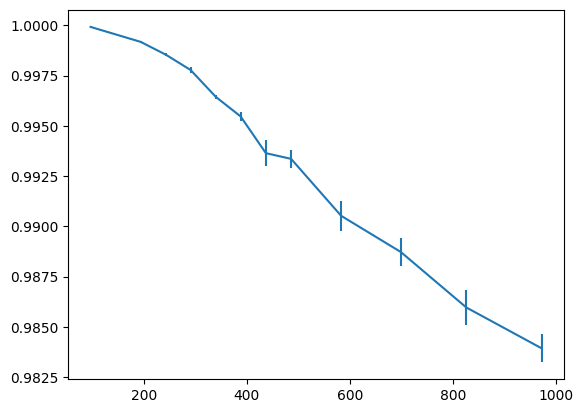

In [34]:
plt.errorbar(lc_scores.index, lc_scores['train'], yerr=lc_scores['train_std'])
plt.title('Train R2 vs Training Size')
plt.xlabel('Data from X_train for fitting')
plt.show()

#### Fit to training set, analyze test set errors

In [4]:
final.fit(X_train,y_train)
y_pred = final.predict(X_test)

In [36]:
test_data = data.loc[y_test.index,:]

In [37]:
residuals = np.abs(y_test - y_pred)
raw_resid = y_test-y_pred

test_data['predicted_margin'] = y_pred
test_data['residuals'] = residuals
test_data['raw_residuals'] = y_test-y_pred

right_side = test_data[(test_data['predicted_margin']>0)
                       &(test_data['home_win']==True)].index

test_data.loc[:,'correct_outcome'] = False
test_data.loc[right_side,'correct_outcome'] = True

In [94]:
test_data.correct_outcome.value_counts(), test_data.home_win.value_counts()

(True     164
 False    141
 Name: correct_outcome, dtype: int64,
 True     176
 False    129
 Name: home_win, dtype: int64)

In [95]:
164/(164+141), 176/(176+129)

(0.5377049180327869, 0.5770491803278689)

In [97]:
120+166+19, 164+141

(305, 305)

In [96]:
(120+166)/(120+166+19)

0.9377049180327869

In [56]:
(3*test_data['residuals']+1).astype(int)

1544     2
2693     2
2993    12
2719     2
2434     1
        ..
1380     6
1886     9
2321     1
2150     5
2899     1
Name: residuals, Length: 305, dtype: int32

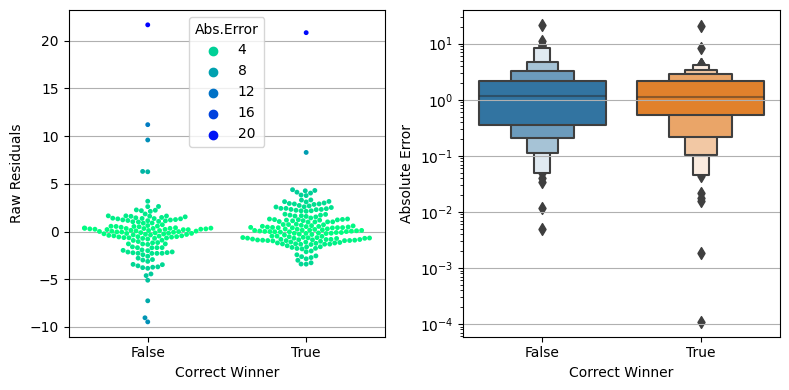

In [92]:
plt.figure(figsize=(8,4), tight_layout=True)
plt.subplot(121)
sns.swarmplot(test_data, y = 'raw_residuals',
              x = 'correct_outcome',
              hue='residuals', size=3.5,
              palette='winter_r',)
plt.ylabel('Raw Residuals')
plt.xlabel('Correct Winner')
plt.legend(title='Abs.Error')
plt.grid(axis='y')

plt.subplot(122)
sns.boxenplot(test_data, y = 'residuals',
              x = 'correct_outcome')
plt.ylabel('Absolute Error')
plt.xlabel('Correct Winner')
plt.yscale('log')
plt.grid(axis='y')

plt.savefig('graphs/Model/residual analysis/residual_by_outcome.png')
plt.show()

In [7]:
test_data.sort_values('residuals',ascending=False).head(10).T.to_csv('worst_predictions.csv')

In [9]:
test_data.sort_values('residuals',ascending=False).head(6).T

,1977,2353,1974,2021,2964,1982
game,2013-05-04-DC-NY,2018-07-14-DET-PIT,2013-05-03-MIN-MAD,2013-06-16-ROC-TOR,2022-11-12-allstar-game,2013-05-11-CHI-MIN
date,2013-05-04 17:00:00+00:00,2018-07-14 18:00:00+00:00,2013-05-03 20:00:00+00:00,2013-06-16 14:00:00+00:00,2022-11-12 16:00:00+00:00,2013-05-11 20:00:00+00:00
home,Empire,Thunderbirds,Radicals,Rush,SW All-Stars,Wind Chill
away,Breeze,Mechanix,Wind Chill,Dragons,EC All-Stars,Union
home_score,25,32,19,25,24,15
away_score,11,10,15,22,42,18
home_completions,246,190,252,244,264,160
away_completions,268,190,221,145,241,256
home_throws,267,208,275,264,294,185
away_throws,268,209,235,145,262,285


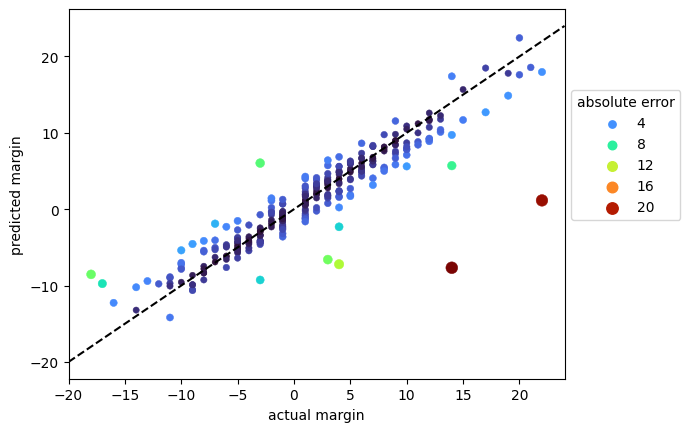

In [95]:
sns.scatterplot(x=y_test, y=y_pred, hue=residuals, 
                palette='turbo', edgecolor='face',
                size=residuals,)# alpha=residuals/residuals.max())
xlim = plt.xlim()
plt.plot(xlim,xlim, 'k--')
plt.xlim(xlim)
plt.legend(title='absolute error', ncols=1, bbox_to_anchor=(1,0.8), loc='best')
plt.ylabel('predicted margin')
plt.xlabel('actual margin')
#plt.grid()
plt.savefig('graphs/Model/final_predicted-vs-actual.png', bbox_inches='tight')
plt.show()

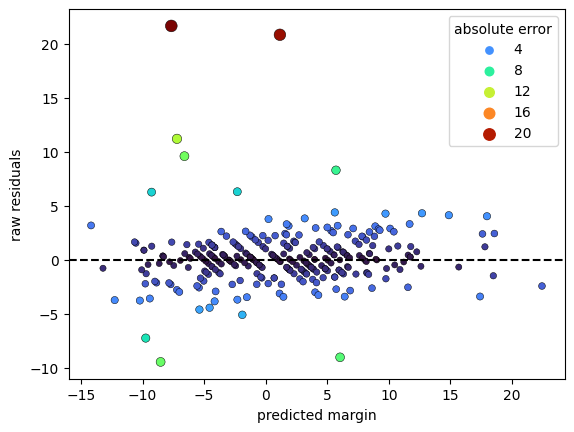

In [65]:
sns.scatterplot(x=y_pred, y=raw_resid, hue=residuals, 
                palette='turbo', edgecolor='k',
                size=residuals)
xlim = plt.xlim()
plt.plot(xlim,[0,0], 'k--')
plt.xlim(xlim)
plt.legend(title='absolute error')
plt.ylabel('raw residuals')
plt.xlabel('predicted margin')
#plt.grid()
plt.savefig('graphs/Model/final_raw-residual-vs-predicted.png', bbox_inches='tight')
plt.show()

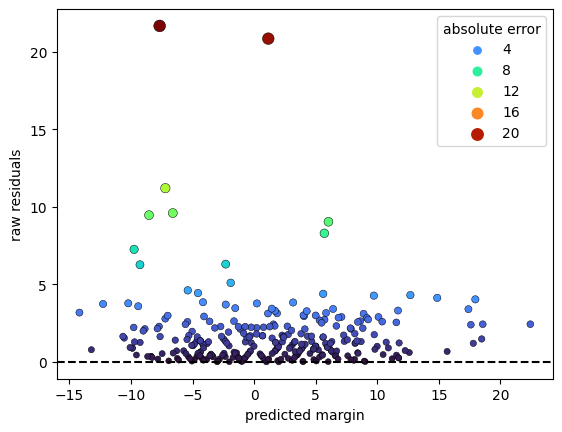

In [66]:
sns.scatterplot(x=y_pred, y=residuals, hue=residuals, 
                palette='turbo', edgecolor='k',
                size=residuals)
xlim = plt.xlim()
plt.plot(xlim,[0,0], 'k--')
plt.xlim(xlim)
plt.legend(title='absolute error')
plt.ylabel('raw residuals')
plt.xlabel('predicted margin')
#plt.grid()
plt.savefig('graphs/Model/final_residual-vs-predicted.png', bbox_inches='tight')
plt.show()

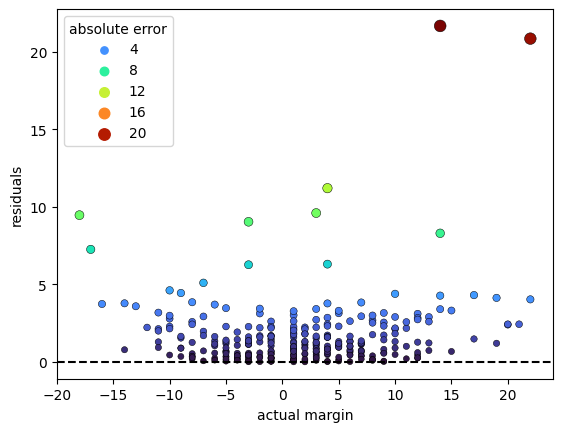

In [67]:
sns.scatterplot(x=y_test, y=residuals, hue=residuals, 
                palette='turbo', edgecolor='k',
                size=residuals)
xlim = plt.xlim()
plt.plot(xlim,[0,0], 'k--')
plt.xlim(xlim)
plt.legend(title='absolute error')
plt.ylabel('residuals')
plt.xlabel('actual margin')
#plt.grid()
plt.savefig('graphs/Model/final_residual-vs-actual.png', bbox_inches='tight')
plt.show()

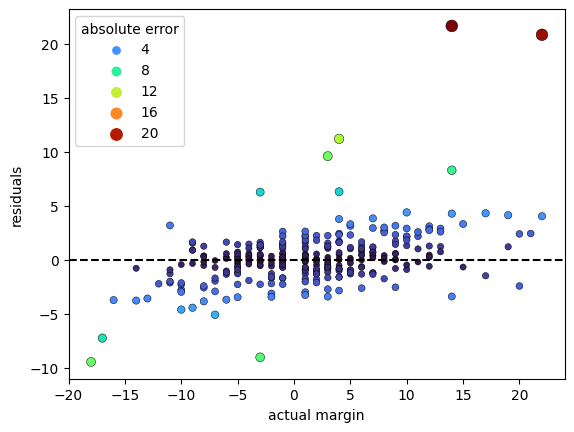

In [68]:
sns.scatterplot(x=y_test, y=raw_resid, hue=residuals, 
                palette='turbo', edgecolor='k',
                size=residuals)
xlim = plt.xlim()
plt.plot(xlim,[0,0], 'k--')
plt.xlim(xlim)
plt.legend(title='absolute error')
plt.ylabel('residuals')
plt.xlabel('actual margin')
#plt.grid()
plt.savefig('graphs/Model/final_raw-residual-vs-actual.png', bbox_inches='tight')
plt.show()

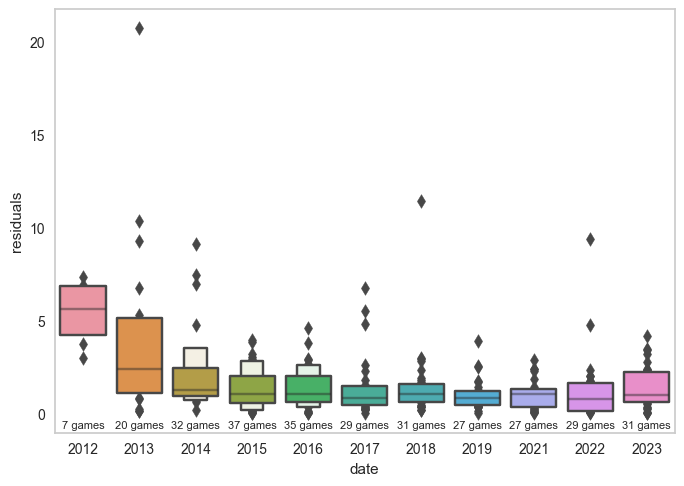

In [638]:
sns.boxenplot(test_data, y='residuals', x=test_data.date.dt.year)
plt.grid(axis='y')
# plt.savefig('graphs/Model/final_residual-by-year.png', bbox_inches='tight')

counts = test_data.date.dt.year.value_counts().sort_index()
for i,val in enumerate(counts.index):
    plt.text(i, -.8, f'{counts[val]} games',
            ha='center', fontsize=8)

plt.savefig('graphs/Model/final_residual-vs-season.png', bbox_inches='tight')

plt.show()

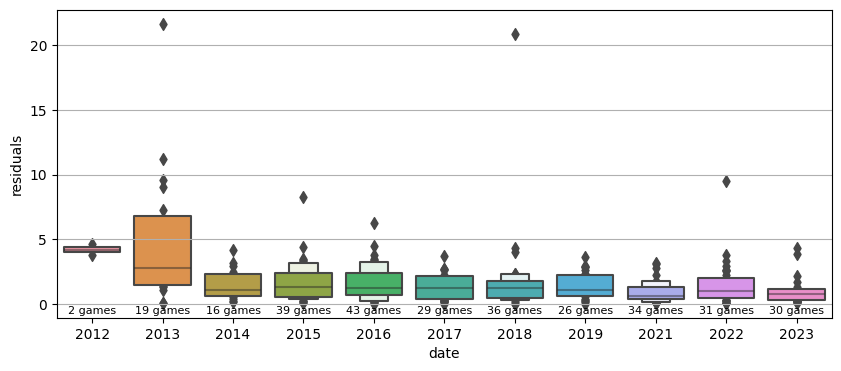

In [16]:
plt.figure(figsize=(10,4), dpi=100)
sns.boxenplot(test_data, y='residuals', x=test_data.date.dt.year)
plt.grid(axis='y')
# plt.savefig('graphs/Model/final_residual-by-year.png', bbox_inches='tight')

counts = test_data.date.dt.year.value_counts().sort_index()
for i,val in enumerate(counts.index):
    plt.text(i, -.8, f'{counts[val]} games',
            ha='center', fontsize=8)

plt.savefig('graphs/Model/final_residual-vs-season.png', bbox_inches='tight')

plt.show()

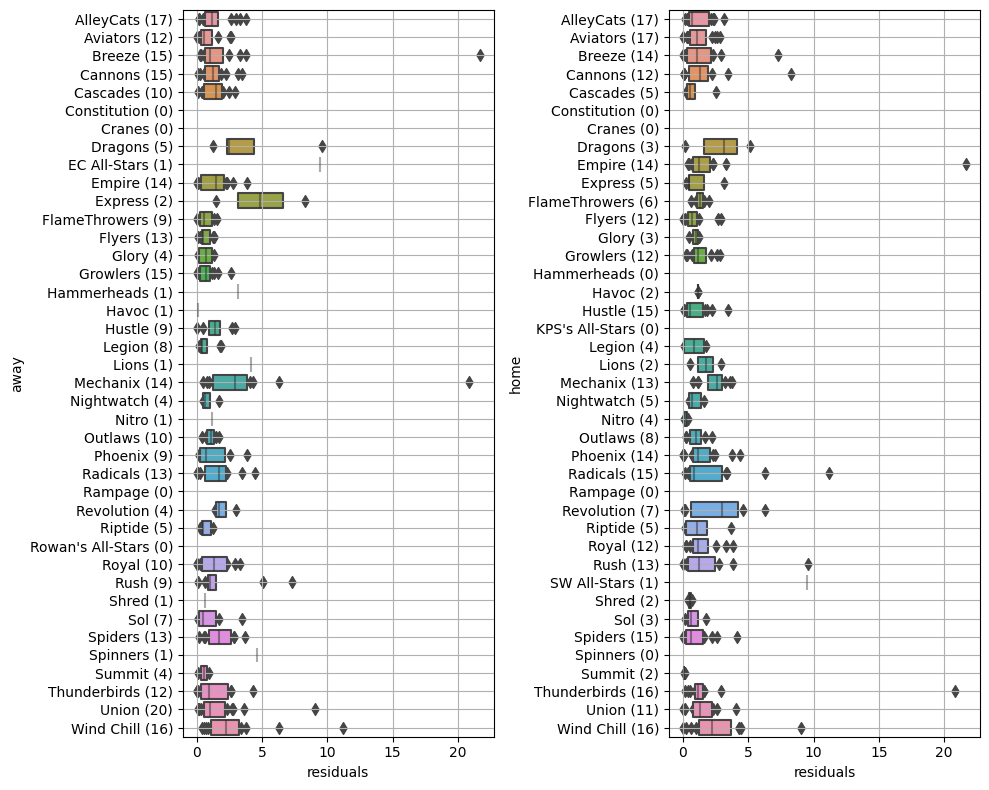

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,8), tight_layout=True)

sns.boxenplot(test_data, x='residuals', y='away', ax=ax1)
ax1.grid()
ticks = ax1.get_yticks()
ax1.set_yticks(ticks = ticks, 
           labels=[f"{val[0]} ({val[1]})" for val in test_data.value_counts('away').sort_index().items()]
          )

sns.boxenplot(test_data, x='residuals', y='home', ax=ax2)
ax2.grid()
ticks = ax2.get_yticks()
ax2.set_yticks(ticks = ticks, 
           labels=[f"{val[0]} ({val[1]})" for val in test_data.value_counts('home').sort_index().items()]
          )

plt.savefig('graphs/Model/final_residual-by-team.png', bbox_inches='tight')
plt.show()

In [ ]:
teams = pd.read_parquet('data/clean_1/team_info_2023-09-19.parquet')

In [ ]:
display(teams.drop(columns=['primary','secondary']).sort_values('games', ascending=False).style
    .background_gradient(subset=['wins'], cmap='viridis_r')
    .background_gradient(subset=['losses'], cmap='viridis')
    .background_gradient(subset=['games'], cmap='bone'))

### Other Plots
 - feature importance for top_tuned models

In [153]:
from sklearn.inspection import partial_dependence, permutation_importance

In [8]:
top_tuned

# order: kNN, GBR, CatBoost, XGB
# model blends would be next, if created

[Pipeline(steps=[('kbst',
                  SelectKBest(k=7,
                              score_func=<function f_regression at 0x000001E9210BF130>)),
                 ('KNeighborsRegressor',
                  KNeighborsRegressor(algorithm='kd_tree', leaf_size=34,
                                      n_jobs=-1, n_neighbors=7,
                                      weights='distance'))]),
 Pipeline(steps=[('norm', StandardScaler()),
                 ('GradientBoostingRegressor',
                  GradientBoostingRegressor(learning_rate=0.13355022016523652,
                                            loss='huber', n_estimators=182,
                                            random_state=42))]),
 Pipeline(steps=[('norm', StandardScaler()),
                 ('CatBoostRegressor',
                  <catboost.core.CatBoostRegressor object at 0x000001E92308A7D0>)]),
 Pipeline(steps=[('norm', StandardScaler()),
                 ('XGBRegressor',
                  XGBRegressor(base_score=None, b

In [9]:
model_params

{'KNeighborsRegressor': {'KNeighborsRegressor__algorithm': 'kd_tree',
  'KNeighborsRegressor__leaf_size': 34,
  'KNeighborsRegressor__n_neighbors': 7,
  'KNeighborsRegressor__p': 2,
  'KNeighborsRegressor__weights': 'distance'},
 'GradientBoostingRegressor': {'GradientBoostingRegressor__learning_rate': 0.13355022016523652,
  'GradientBoostingRegressor__loss': 'huber',
  'GradientBoostingRegressor__n_estimators': 182},
 'CatBoostRegressor': {'CatBoostRegressor__l2_leaf_reg': 1.49816047538945,
  'CatBoostRegressor__learning_rate': 0.027804851956917426,
  'CatBoostRegressor__random_strength': 2.5985284373248057},
 'XGBRegressor': {'XGBRegressor__colsample_bytree': 0.7181162353675755,
  'XGBRegressor__eta': 0.2894966808967191,
  'XGBRegressor__gamma': 0.018169482974997143,
  'XGBRegressor__max_depth': 3,
  'XGBRegressor__subsample': 0.9468289274320415}}

In [96]:
interactions = top_tuned[2][-1].get_feature_importance(prettified=True, type='Interaction')
top_interactions = interactions.head(4)
col_index = {i:val for i,val in enumerate(X.columns)}
top_interactions.rename(columns = {'First Feature Index':'Feature One', 'Second Feature Index':'Feature Two'}, inplace=True)

# older version of pandas on this kernel, should use apply now
top_interactions[['Feature One','Feature Two']] = \
top_interactions[['Feature One','Feature Two']].applymap(lambda x: col_index[x])

In [119]:
top_interactions

,Feature One,Feature Two,Interaction
0,away_blocks,block_turnover_diff,3.491273
1,home_turnovers,block_turnover_diff,3.147459
2,comp_rate_diff,block_turnover_diff,3.069596
3,home_throws,block_turnover_diff,2.950610


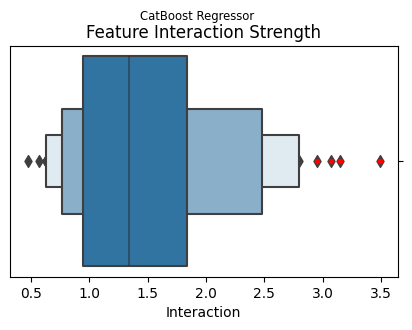

In [146]:
plt.figure(figsize=(5,3))

sns.boxenplot(x = interactions.Interaction)
plt.suptitle('CatBoost Regressor', fontsize='small', y=1)
plt.title('Feature Interaction Strength')
plt.plot(top_interactions.Interaction,np.zeros(4), 'r.')
plt.savefig('graphs/Model/CatBoost Feature Interaction distribution.png', bbox_inches='tight')
plt.show()

In [149]:
interactions.Interaction.median(), interactions.Interaction.mean()

(1.3429278288386421, 1.515151515151516)

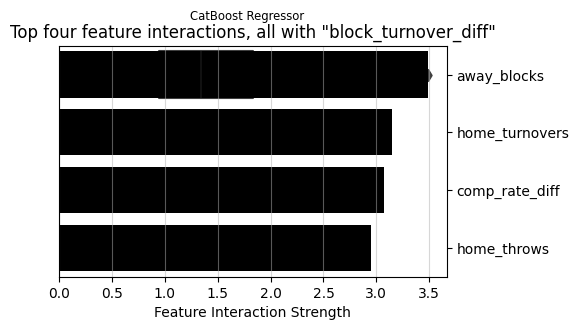

In [151]:
plt.figure(figsize=(5,3))
sns.barplot(top_interactions, x='Interaction', y='Feature One', color='k')
plt.grid(axis='x', alpha=0.5)
plt.title('Top four feature interactions, all with "block_turnover_diff"')
plt.ylabel('')
plt.suptitle('CatBoost Regressor', fontsize='small', y=1)
plt.xlabel('Feature Interaction Strength')
plt.savefig('graphs/Model/CatBoost Feature Interaction.png', bbox_inches='tight')
plt.show()

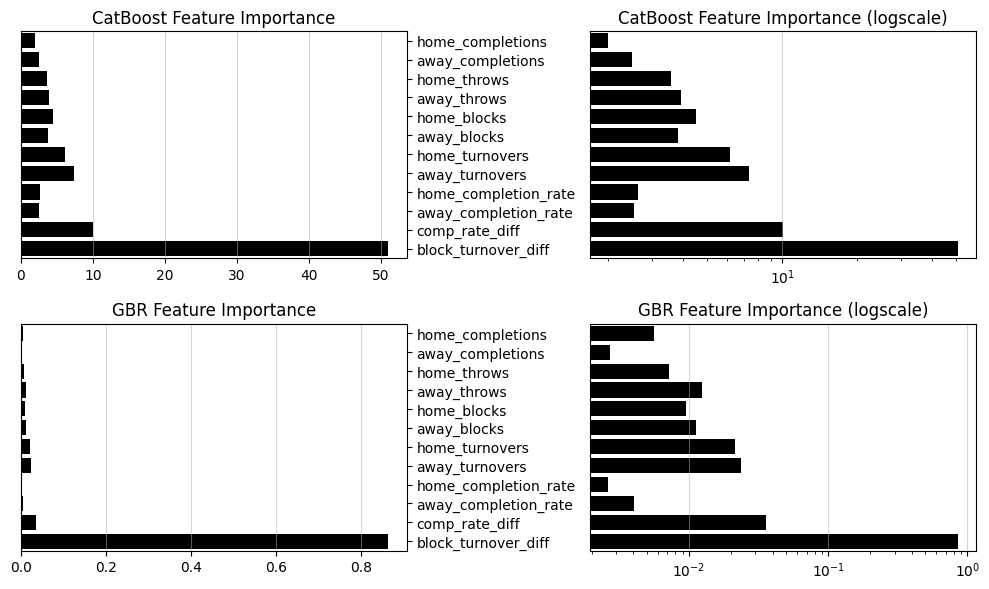

In [77]:
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = False

plt.figure(figsize=(10,6), tight_layout=True)
plt.subplot(221)
sns.barplot(x=top_tuned[2][-1].get_feature_importance(), y=features, color='k')
plt.title('CatBoost Feature Importance')
plt.grid(axis='x', which='both', alpha=0.5)

plt.subplot(222)
sns.barplot(x=top_tuned[2][-1].get_feature_importance(), y=features, color='k')
plt.title('CatBoost Feature Importance (logscale)')
plt.grid(axis='x', alpha=0.5)
plt.xscale('log')
plt.yticks([])

plt.subplot(223)
sns.barplot(x=top_tuned[1][-1].feature_importances_, y=features, color='k')
plt.title('GBR Feature Importance')
plt.grid(axis='x', which='both', alpha=0.5)

plt.subplot(224)
sns.barplot(x=top_tuned[1][-1].feature_importances_, y=features, color='k')
plt.title('GBR Feature Importance (logscale)')
plt.grid(axis='x', alpha=0.5)
plt.xscale('log')
plt.yticks([])

plt.savefig('graphs/Model/feature_importance.png', bbox_inches='tight')
plt.show()

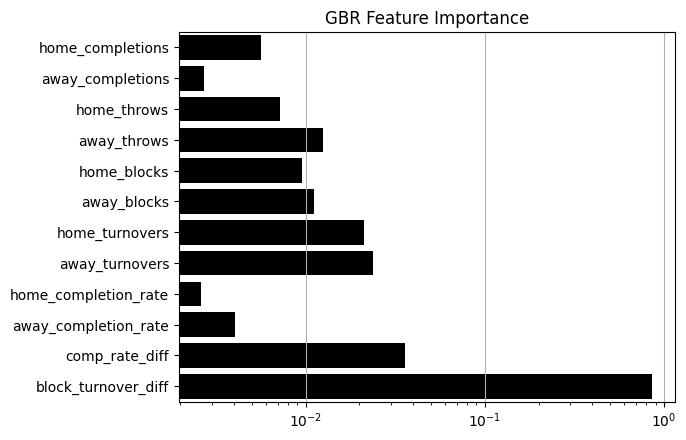

In [12]:
sns.barplot(x=top_tuned[1][-1].feature_importances_, y=features, color='k')
plt.title('GBR Feature Importance')
plt.grid(axis='x')
plt.xscale('log')
plt.show()

In [152]:
top_tuned[1][-1]

GradientBoostingRegressor(learning_rate=0.13355022016523652, loss='huber',
                          n_estimators=182, random_state=42)

In [195]:
gbr_pi = permutation_importance(top_tuned[1][-1], X_test, y_test, n_repeats=11, random_state=42, n_jobs=-1)

C:\Users\Nish\Classes\springboard\kaggle\playground-series-s3e24_smoker status binary prediction\venv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


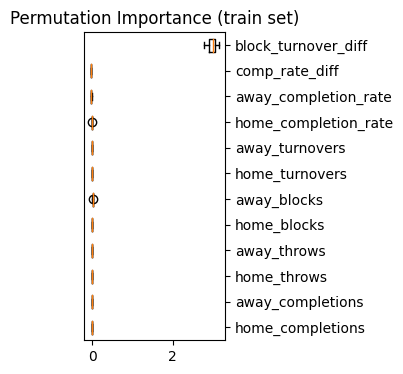

In [194]:
plt.figure(figsize=(4,4))
plt.subplot(1, 2, 2)
plt.boxplot(
    gbr_pi.importances.T,
    vert=False,
    labels=X.columns,
)
# plt.xscale('log')
#plt.ylim((10,13))
plt.title("Permutation Importance (train set)")
plt.show()

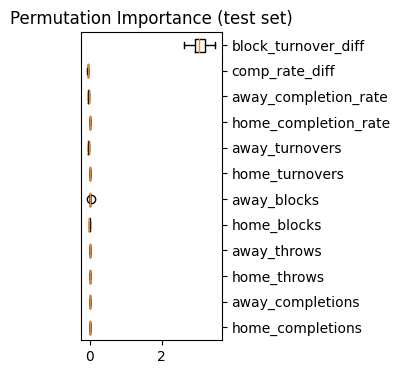

In [196]:
plt.figure(figsize=(4,4))
plt.subplot(1, 2, 2)
plt.boxplot(
    gbr_pi.importances.T,
    vert=False,
    labels=X.columns,
)
# plt.xscale('log')
#plt.ylim((10,13))
plt.title("Permutation Importance (test set)")
plt.show()

#### Compare to CatBoost (2nd place)

In [77]:
top_tuned[2]

Pipeline(steps=[('norm', StandardScaler()),
                ('CatBoostRegressor',
                 <catboost.core.CatBoostRegressor object at 0x0000026DC08A20E0>)])

In [78]:
final = top_tuned[2]

In [79]:
final.fit(X_train,y_train)
y_pred = final.predict(X_test)

test_data = data.loc[y_test.index,:]

residuals = np.abs(y_test - y_pred)
raw_resid = y_test-y_pred

test_data['predicted_margin'] = y_pred
test_data['residuals'] = residuals

In [80]:

test_data.sort_values('residuals',ascending=False).head(6).T

,1977,2353,1974,2964,1982,2021
game,2013-05-04-DC-NY,2018-07-14-DET-PIT,2013-05-03-MIN-MAD,2022-11-12-allstar-game,2013-05-11-CHI-MIN,2013-06-16-ROC-TOR
date,2013-05-04 17:00:00+00:00,2018-07-14 18:00:00+00:00,2013-05-03 20:00:00+00:00,2022-11-12 16:00:00+00:00,2013-05-11 20:00:00+00:00,2013-06-16 14:00:00+00:00
home,Empire,Thunderbirds,Radicals,SW All-Stars,Wind Chill,Rush
away,Breeze,Mechanix,Wind Chill,EC All-Stars,Union,Dragons
home_score,25,32,19,24,15,25
away_score,11,10,15,42,18,22
home_completions,246,190,252,264,160,244
away_completions,268,190,221,241,256,145
home_throws,267,208,275,294,185,264
away_throws,268,209,235,262,285,145


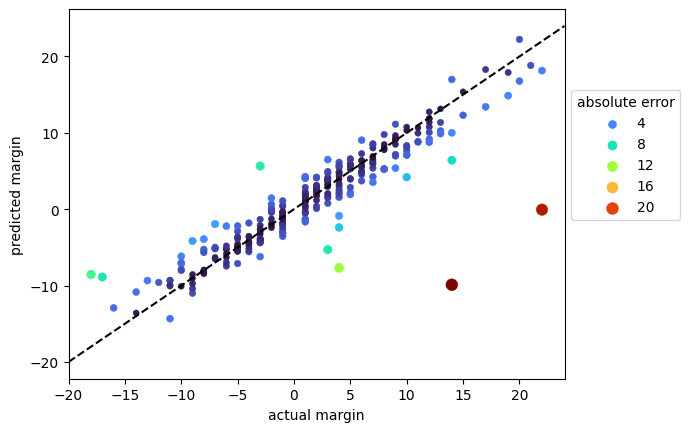

In [81]:

sns.scatterplot(x=y_test, y=y_pred, hue=residuals, 
                palette='turbo', edgecolor='face',
                size=residuals,)# alpha=residuals/residuals.max())
xlim = plt.xlim()
plt.plot(xlim,xlim, 'k--')
plt.xlim(xlim)
plt.legend(title='absolute error', ncols=1, bbox_to_anchor=(1,0.8), loc='best')
plt.ylabel('predicted margin')
plt.xlabel('actual margin')
#plt.grid()
plt.savefig('graphs/Model/final2_predicted-vs-actual.png', bbox_inches='tight')
plt.show()

In [ ]:
sns.scatterplot(x=y_pred, y=residuals, hue=residuals, 
                palette='turbo', edgecolor='k',
                size=residuals)
xlim = plt.xlim()
plt.plot(xlim,[0,0], 'k--')
plt.xlim(xlim)
plt.legend(title='absolute error')
plt.ylabel('residuals')
plt.xlabel('predicted margin')
#plt.grid()
plt.savefig('graphs/Model/final2_residual-vs-predicted.png', bbox_inches='tight')
plt.show()

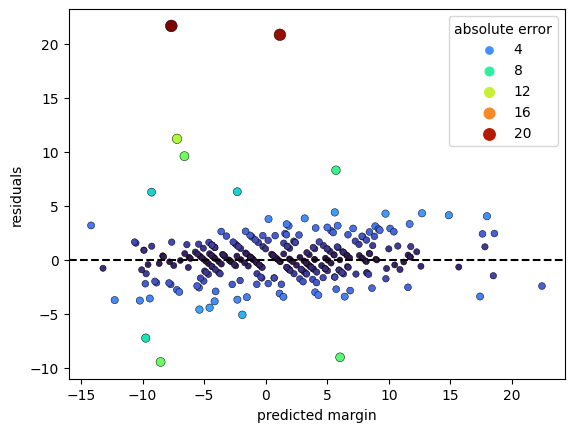

In [69]:
sns.scatterplot(x=y_pred, y=raw_resid, hue=residuals, 
                palette='turbo', edgecolor='k',
                size=residuals)
xlim = plt.xlim()
plt.plot(xlim,[0,0], 'k--')
plt.xlim(xlim)
plt.legend(title='absolute error')
plt.ylabel('residuals')
plt.xlabel('predicted margin')
#plt.grid()
plt.savefig('graphs/Model/final2_raw-residual-vs-predicted.png', bbox_inches='tight')
plt.show()

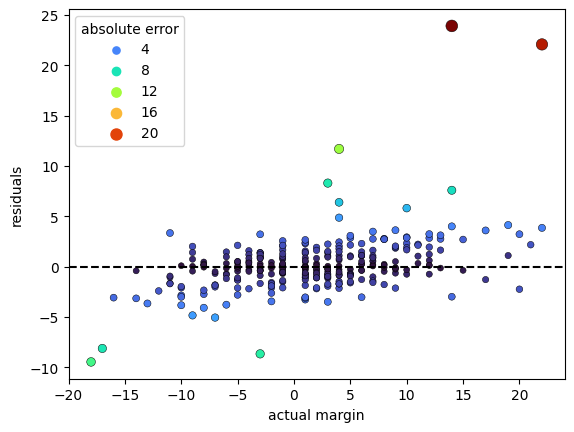

In [33]:
sns.scatterplot(x=y_test, y=raw_resid, hue=residuals, 
                palette='turbo', edgecolor='k',
                size=residuals)
xlim = plt.xlim()
plt.plot(xlim,[0,0], 'k--')
plt.xlim(xlim)
plt.legend(title='absolute error')
plt.ylabel('residuals')
plt.xlabel('actual margin')
#plt.grid()
plt.savefig('graphs/Model/final2_residual-vs-actual.png', bbox_inches='tight')
plt.show()


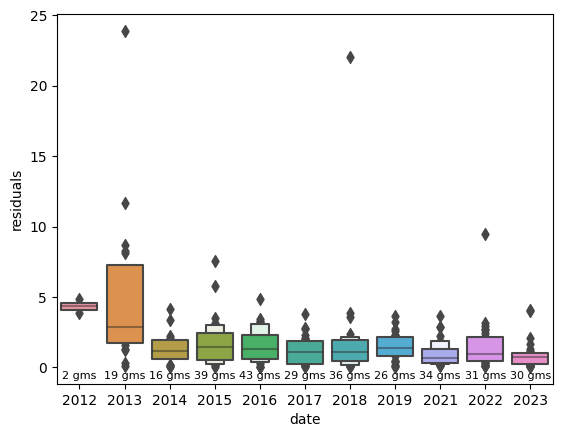

In [87]:
sns.boxenplot(test_data, y='residuals', x=test_data.date.dt.year)
#plt.grid(axis='y')
# plt.savefig('graphs/Model/final_residual-by-year.png', bbox_inches='tight')

counts = test_data.date.dt.year.value_counts().sort_index()
for i,val in enumerate(counts.index):
    plt.text(i, -.8, f'{counts[val]} gms',
            ha='center', fontsize=8)

plt.savefig('graphs/Model/final2_residual-vs-season.png', bbox_inches='tight')
#plt.grid()
plt.show()